<a href="https://colab.research.google.com/github/neutrinoox/projet7-scoring/blob/main/V_Maxime_2_notebook_mod%C3%A9lisation_092025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contexte et objectifs
   Ce notebook pr√©pare un pipeline reproductible pour le scoring de cr√©dit. Il structure le chargement des donn√©es, le feature engineering, puis les baselines de mod√©lisation.

In [ ]:
import os
from pathlib import Path
import pandas as pd

In [ ]:
# D√©finit le chemin racine des donn√©es
DATA_DIR = Path("data")

# Cr√©e le dossier de cache
DATA_DIR.mkdir(exist_ok=True)

In [ ]:
# D√©finit le dictionnaire des fichiers √† charger
FILES = {
    "application_train": "application_train.csv",
    "application_test": "application_test.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "credit_card_balance": "credit_card_balance.csv",
    "installments_payments": "installments_payments.csv",
    "POS_CASH_balance": "POS_CASH_balance.csv",
    "previous_application": "previous_application.csv",
    "HomeCredit_columns_description": "HomeCredit_columns_description.csv",
    "sample_submission": "sample_submission.csv",
}

# Charge tous les fichiers dans un dictionnaire
raw_data = {}
for name, filename in FILES.items():
    # Construit le chemin final du fichier source
    filepath = DATA_DIR / filename
    # Lit le CSV concern√© en conservant les types par d√©faut
    try:
        raw_data[name] = pd.read_csv(filepath, encoding="utf-8", sep=',', low_memory=False, on_bad_lines='warn')
    except UnicodeDecodeError:
        raw_data[name] = pd.read_csv(filepath, encoding="latin1", sep=',', low_memory=False, on_bad_lines='warn')

/tmp/ipython-input-2232238573.py:22: ParserWarning: Skipping line 55462: expected 37 fields, saw 54

  raw_data[name] = pd.read_csv(filepath, encoding="utf-8", sep=',', low_memory=False, on_bad_lines='warn')


In [ ]:
def eda_basique(df, nom_df="DataFrame"):
    print(f"\n--- Analyse de {nom_df} ---")

    # Dimensions du DataFrame
    print(f"Shape (lignes, colonnes) : {df.shape}")

    # Liste des colonnes
    print("\n Colonnes :")
    print(df.columns.tolist())

    # Valeurs manquantes
    print("\n Valeurs manquantes (par colonne) :")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    display(missing.to_frame(name="Nb de NaN"))

    # Statistiques descriptives
    print("\n Statistiques descriptives (variables num√©riques) :")
    display(df.describe().transpose())

    # Exemple de donn√©es
    print("\n Extrait (premi√®res lignes) :")
    display(df.head())

In [ ]:
eda_basique(raw_data['sample_submission'], "sample_submission")


--- Analyse de sample_submission ---
Shape (lignes, colonnes) : (48744, 2)

 Colonnes :
['SK_ID_CURR', 'TARGET']

 Valeurs manquantes (par colonne) :


Empty DataFrame
Columns: [Nb de NaN]
Index: []


 Statistiques descriptives (variables num√©riques) :


count          mean            std       min        25%  \
SK_ID_CURR  48744.0  277796.67635  103169.547296  100001.0  188557.75   
TARGET      48744.0       0.50000       0.000000       0.5       0.50   

                 50%       75%       max  
SK_ID_CURR  277549.0  367555.5  456250.0  
TARGET           0.5       0.5       0.5


 Extrait (premi√®res lignes) :


SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

## Analyse du fichier `sample_submission.csv`

Ce fichier contient **2 colonnes** :
- `SK_ID_CURR` : l‚Äôidentifiant unique d‚Äôun client.
- `TARGET` : une valeur de pr√©diction **fictive**, ici toujours √† `0.5`.

Ce fichier est un **exemple de format de soumission** pour des comp√©titions de type Kaggle. Il montre √† quoi devrait ressembler un fichier contenant les pr√©dictions finales du mod√®le pour le jeu de test (`application_test.csv`).

---

###  Pourquoi ce fichier ne sera **pas utilis√©** dans le projet

Dans notre contexte, on ne participe **pas √† une comp√©tition Kaggle**, mais on d√©veloppe un **dashboard interactif** pour expliquer les d√©cisions d‚Äôoctroi de cr√©dit.  
Nous allons donc nous appuyer sur :
- les **vraies donn√©es clients** (`application_train.csv`, `application_test.csv`),
- et notre **mod√®le/API existant** pour produire les scores.

Le fichier `sample_submission.csv` ne nous est **d‚Äôaucune utilit√© directe** ici.

In [ ]:
eda_basique(raw_data['POS_CASH_balance'], "POS_CASH_balance")


--- Analyse de POS_CASH_balance ---
Shape (lignes, colonnes) : (453717, 8)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

 Valeurs manquantes (par colonne) :


Nb de NaN
CNT_INSTALMENT_FUTURE        704
CNT_INSTALMENT               702
NAME_CONTRACT_STATUS           1
SK_DPD                         1
SK_DPD_DEF                     1


 Statistiques descriptives (variables num√©riques) :


count          mean            std        min  \
SK_ID_PREV             453717.0  1.903936e+06  535596.987128  1000001.0   
SK_ID_CURR             453717.0  2.787908e+05  102814.182221   100003.0   
MONTHS_BALANCE         453717.0 -2.673459e+01      23.723450      -96.0   
CNT_INSTALMENT         453015.0  2.045353e+01      14.112832        1.0   
CNT_INSTALMENT_FUTURE  453013.0  1.303106e+01      12.932101        0.0   
SK_DPD                 453716.0  3.594517e-01      15.728253        0.0   
SK_DPD_DEF             453716.0  6.820787e-02       1.448846        0.0   

                             25%        50%        75%        max  
SK_ID_PREV             1434139.0  1897530.0  2369271.0  2843497.0  
SK_ID_CURR              189888.0   279269.0   368163.0   456255.0  
MONTHS_BALANCE             -40.0      -17.0      -10.0       -1.0  
CNT_INSTALMENT              10.0       14.0       24.0       72.0  
CNT_INSTALMENT_FUTURE        4.0        9.0       18.0       70.0  
SK_DPD                       0.0        0.0        0.0     2672.0  
SK_DPD_DEF                   0.0        0.0        0.0      268.0


 Extrait (premi√®res lignes) :


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active     0.0         0.0  
1                   35.0               Active     0.0         0.0  
2                    9.0               Active     0.0         0.0  
3                   42.0               Active     0.0         0.0  
4                   35.0               Active     0.0         0.0

## Analyse du fichier `POS_CASH_balance.csv`

Ce fichier contient des **informations mensuelles** sur les cr√©dits **POS (point of sale)** ou **CASH** contract√©s par les clients.

Chaque ligne correspond √† **un mois de suivi d‚Äôun cr√©dit** (d‚Äôo√π la colonne `MONTHS_BALANCE`).

| Colonne | Signification | Utile pour le projet ? |
|---------|---------------|------------------------|
| `SK_ID_PREV` | ID de la demande de cr√©dit (li√©e √† un client) | Non, identifiant technique |
| `SK_ID_CURR` | ID du client (cl√© principale) | Oui, pour relier au client |
| `MONTHS_BALANCE` | Mois relatif : 0 = mois actuel, -1 = mois pr√©c√©dent, etc. | Peut √™tre utile si analyse temporelle |
| `CNT_INSTALMENT` | Nombre total d‚Äô√©ch√©ances pr√©vues du cr√©dit | Potentiellement utile (longueur du cr√©dit) |
| `CNT_INSTALMENT_FUTURE` | Nombre d‚Äô√©ch√©ances restantes √† ce moment-l√† | Oui (endettement restant) |
| `NAME_CONTRACT_STATUS` | Statut du cr√©dit ce mois-l√† (Active, Completed, etc.) | Oui (situation actuelle ou pass√©e) |
| `SK_DPD` | Jours de retard de paiement (jours de retard > 0) | Oui (comportement de remboursement) |
| `SK_DPD_DEF` | Jours de retard "d√©faut" (d√©passant un seuil critique)  Oui (indicateur fort de d√©faut) |

---

- Les colonnes `SK_DPD` et `SK_DPD_DEF` sont int√©ressantes pour mesurer **la fiabilit√© de remboursement pass√©e** d‚Äôun client.
- Les colonnes `CNT_INSTALMENT` et `CNT_INSTALMENT_FUTURE` donnent une id√©e de **l‚Äô√©tat d‚Äôun cr√©dit en cours**.
- Le statut du contrat (`NAME_CONTRACT_STATUS`) permet de savoir si le cr√©dit est **encore actif ou termin√©**.

- Ce fichier contient **beaucoup de lignes (plus de 100 000)** car il suit les cr√©dits mois par mois.
- Il faudrait le **r√©sumer** pour pouvoir l‚Äôutiliser dans le dashboard (par exemple : nombre de cr√©dits actifs, total de jours de retard moyen, etc.).
- Cela demande un **pr√©traitement avanc√©** (agr√©gations par client), ce qui d√©passe le besoin imm√©diat du dashboard centr√© sur **l‚Äôinterpr√©tation d‚Äôun score individuel**.

**Conclusion** : Ce fichier est **int√©ressant pour enrichir un mod√®le**, mais il ne sera **pas utilis√© directement** dans le dashboard sans pr√©traitement.

In [13]:
eda_basique(raw_data['installments_payments'], "installments_payments")


--- Analyse de installments_payments ---
Shape (lignes, colonnes) : (2959199, 8)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

 Valeurs manquantes (par colonne) :


Nb de NaN
NUM_INSTALMENT_VERSION          1
NUM_INSTALMENT_NUMBER           1
DAYS_INSTALMENT                 1
DAYS_ENTRY_PAYMENT              1
AMT_INSTALMENT                  1
AMT_PAYMENT                     1


 Statistiques descriptives (variables num√©riques) :


count          mean            std        min  \
SK_ID_PREV              2959199.0  1.901124e+06  536063.674142  1000001.0   
SK_ID_CURR              2959199.0  1.501385e+05   28908.875665        1.0   
NUM_INSTALMENT_VERSION  2959198.0  8.551222e-01       0.998934        0.0   
NUM_INSTALMENT_NUMBER   2959198.0  1.893174e+01      26.834012        1.0   
DAYS_INSTALMENT         2959198.0 -1.044788e+03     801.904941    -2922.0   
DAYS_ENTRY_PAYMENT      2959198.0 -1.053591e+03     801.503992    -3115.0   
AMT_INSTALMENT          2959198.0  1.707452e+04   51152.167607        0.0   
AMT_PAYMENT             2959198.0  1.724955e+04   55281.879199        0.0   

                                25%         50%         75%          max  
SK_ID_PREV              1431164.000  1895664.00  2366409.00  2843491.000  
SK_ID_CURR               125154.000   150096.00   175295.00   199999.000  
NUM_INSTALMENT_VERSION        0.000        1.00        1.00       43.000  
NUM_INSTALMENT_NUMBER         4.000        8.00       19.00      244.000  
DAYS_INSTALMENT           -1658.000     -822.00     -362.00       -2.000  
DAYS_ENTRY_PAYMENT        -1667.000     -831.00     -371.00       -2.000  
AMT_INSTALMENT             4225.995     8882.28    16660.98  3473582.895  
AMT_PAYMENT                3399.660     8127.45    16056.81  3473582.895


 Extrait (premi√®res lignes) :


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                    6.0   
1     1330831      151639                     0.0                   34.0   
2     2085231      193053                     2.0                    1.0   
3     2452527      199697                     1.0                    3.0   
4     2714724      167756                     1.0                    2.0   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

## Analyse du fichier `installments_payments.csv`

Ce fichier contient des informations d√©taill√©es sur les **paiements effectu√©s par les clients** sur leurs cr√©dits pr√©c√©dents, √©ch√©ance par √©ch√©ance.

Chaque ligne correspond √† un **paiement pr√©vu vs r√©el** pour un cr√©dit donn√©.

---

| Colonne | Signification | Utile pour le projet ? |
|---------|---------------|------------------------|
| `SK_ID_PREV` | ID de la demande de cr√©dit |  Non |
| `SK_ID_CURR` | ID du client (cl√© principale) | Oui |
| `NUM_INSTALMENT_VERSION` | Version de l‚Äô√©ch√©ancier | Non |
| `NUM_INSTALMENT_NUMBER` | Num√©ro de l‚Äô√©ch√©ance (1er, 2e, etc.) | Pas directement |
| `DAYS_INSTALMENT` | Jour pr√©vu pour l‚Äô√©ch√©ance (relatif au jour actuel) | Oui, Pour √©valuer la ponctualit√© |
| `DAYS_ENTRY_PAYMENT` | Jour r√©el du paiement effectu√© | Oui, Pour calculer le retard |
| `AMT_INSTALMENT` | Montant d√ª pour cette √©ch√©ance | Oui, indice du poids des mensualit√©s |
| `AMT_PAYMENT` | Montant r√©ellement pay√© | Oui, Pour savoir si le paiement a √©t√© partiel ou total |

---

Ce fichier est **extr√™mement utile pour comprendre les habitudes de remboursement** des clients dans le pass√© :
- Ponctualit√© : en comparant `DAYS_INSTALMENT` et `DAYS_ENTRY_PAYMENT` ‚Üí si le client est souvent en retard.
- Paiements partiels : en comparant `AMT_INSTALMENT` et `AMT_PAYMENT`.

Je peux en d√©duire des **indicateurs puissants** pour enrichir le mod√®le ou le dashboard :
- Moyenne de retard de paiement.
- % de paiements effectu√©s en totalit√©.
- Nombre d‚Äô√©ch√©ances pay√©es en retard.

Comme `POS_CASH_balance`, ce fichier contient **plusieurs lignes par client**. Il faut donc :
- Faire des **agr√©gations par client** (via `SK_ID_CURR`) pour le r√©sumer.
- Ensuite, int√©grer ces indicateurs dans le mod√®le ou le dashboard.

In [ ]:
eda_basique(raw_data['credit_card_balance'], "credit_card_balance")


--- Analyse de credit_card_balance ---
Shape (lignes, colonnes) : (1674586, 23)

 Colonnes :
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

 Valeurs manquantes (par colonne) :


Nb de NaN
AMT_PAYMENT_CURRENT            344865
AMT_DRAWINGS_ATM_CURRENT       339834
CNT_DRAWINGS_ATM_CURRENT       339834
AMT_DRAWINGS_POS_CURRENT       339834
AMT_DRAWINGS_OTHER_CURRENT     339834
CNT_DRAWINGS_OTHER_CURRENT     339834
CNT_DRAWINGS_POS_CURRENT       339834
CNT_INSTALMENT_MATURE_CUM      123426
AMT_INST_MIN_REGULARITY        123426
AMT_DRAWINGS_CURRENT                1
SK_ID_CURR                          1
AMT_CREDIT_LIMIT_ACTUAL             1
AMT_BALANCE                         1
MONTHS_BALANCE                      1
AMT_TOTAL_RECEIVABLE                1
AMT_RECIVABLE                       1
AMT_RECEIVABLE_PRINCIPAL            1
AMT_PAYMENT_TOTAL_CURRENT           1
CNT_DRAWINGS_CURRENT                1
NAME_CONTRACT_STATUS                1
SK_DPD                              1
SK_DPD_DEF                          1


 Statistiques descriptives (variables num√©riques) :


count          mean            std  \
SK_ID_PREV                  1674586.0  1.904431e+06  536604.993433   
SK_ID_CURR                  1674585.0  2.782943e+05  102689.671396   
MONTHS_BALANCE              1674585.0 -3.374359e+01      27.462162   
AMT_BALANCE                 1674585.0  5.704038e+04  103999.333203   
AMT_CREDIT_LIMIT_ACTUAL     1674585.0  1.522937e+05  164195.114096   
AMT_DRAWINGS_ATM_CURRENT    1334752.0  5.745902e+03   27427.079789   
AMT_DRAWINGS_CURRENT        1674585.0  7.051616e+03   32585.194847   
AMT_DRAWINGS_OTHER_CURRENT  1334752.0  2.732948e+02    7706.041067   
AMT_DRAWINGS_POS_CURRENT    1334752.0  2.812136e+03   20074.460373   
AMT_INST_MIN_REGULARITY     1551160.0  3.475082e+03    5502.827945   
AMT_PAYMENT_CURRENT         1329721.0  1.018075e+04   36003.029408   
AMT_PAYMENT_TOTAL_CURRENT   1674585.0  7.474346e+03   31831.660547   
AMT_RECEIVABLE_PRINCIPAL    1674585.0  5.475021e+04  100296.106582   
AMT_RECIVABLE               1674585.0  5.684458e+04  103670.585864   
AMT_TOTAL_RECEIVABLE        1674585.0  5.685476e+04  103677.749872   
CNT_DRAWINGS_ATM_CURRENT    1334752.0  3.015519e-01       1.074501   
CNT_DRAWINGS_CURRENT        1674585.0  6.678783e-01       3.081963   
CNT_DRAWINGS_OTHER_CURRENT  1334752.0  4.839850e-03       0.082509   
CNT_DRAWINGS_POS_CURRENT    1334752.0  5.315310e-01       3.147545   
CNT_INSTALMENT_MATURE_CUM   1551160.0  2.068518e+01      20.343851   
SK_DPD                      1674585.0  9.213753e+00      98.864911   
SK_DPD_DEF                  1674585.0  3.704804e-01      23.293708   

                                    min          25%          50%  \
SK_ID_PREV                  1000018.000  1431899.000  1897474.000   
SK_ID_CURR                   100006.000   189534.000   278394.000   
MONTHS_BALANCE                  -96.000      -55.000      -26.000   
AMT_BALANCE                 -261471.015        0.000        0.000   
AMT_CREDIT_LIMIT_ACTUAL           0.000    45000.000   112500.000   
AMT_DRAWINGS_ATM_CURRENT          0.000        0.000        0.000   
AMT_DRAWINGS_CURRENT          -1687.500        0.000        0.000   
AMT_DRAWINGS_OTHER_CURRENT        0.000        0.000        0.000   
AMT_DRAWINGS_POS_CURRENT          0.000        0.000        0.000   
AMT_INST_MIN_REGULARITY           0.000        0.000        0.000   
AMT_PAYMENT_CURRENT               0.000      145.395     2718.405   
AMT_PAYMENT_TOTAL_CURRENT         0.000        0.000        0.000   
AMT_RECEIVABLE_PRINCIPAL    -267615.000        0.000        0.000   
AMT_RECIVABLE               -261777.015        0.000        0.000   
AMT_TOTAL_RECEIVABLE        -261777.015        0.000        0.000   
CNT_DRAWINGS_ATM_CURRENT          0.000        0.000        0.000   
CNT_DRAWINGS_CURRENT              0.000        0.000        0.000   
CNT_DRAWINGS_OTHER_CURRENT        0.000        0.000        0.000   
CNT_DRAWINGS_POS_CURRENT          0.000        0.000        0.000   
CNT_INSTALMENT_MATURE_CUM         0.000        4.000       15.000   
SK_DPD                            0.000        0.000        0.000   
SK_DPD_DEF                        0.000        0.000        0.000   

                                    75%          max  
SK_ID_PREV                  2369424.000  2843496.000  
SK_ID_CURR                   367558.000   456250.000  
MONTHS_BALANCE                  -10.000       -1.000  
AMT_BALANCE                   87800.085  1505902.185  
AMT_CREDIT_LIMIT_ACTUAL      180000.000  1350000.000  
AMT_DRAWINGS_ATM_CURRENT          0.000  1676250.000  
AMT_DRAWINGS_CURRENT              0.000  2287098.315  
AMT_DRAWINGS_OTHER_CURRENT        0.000   899910.000  
AMT_DRAWINGS_POS_CURRENT          0.000  1933462.125  
AMT_INST_MIN_REGULARITY        6300.000   126728.145  
AMT_PAYMENT_CURRENT            9000.000  4289207.445  
AMT_PAYMENT_TOTAL_CURRENT      6750.000  4278315.690  
AMT_RECEIVABLE_PRINCIPAL      84179.565  1472316.795  
AMT_RECIVABLE                 87675.435  1493338.185  
AMT_TOTA


 Extrait (premi√®res lignes) :


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384    378907.0            -6.0       56.970   
1     2582071    363914.0            -1.0    63975.555   
2     1740877    371185.0            -7.0    31815.225   
3     1389973    337855.0            -4.0   236572.110   
4     1891521    126868.0            -1.0   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                 135000.0                       0.0                 877.5   
1                  45000.0                    2250.0                2250.0   
2                 450000.0                       0.0                   0.0   
3                 225000.0                    2250.0                2250.0   
4                 450000.0                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                   1.0                         0.0   
1                       1.0                   1.0                         0.0   
2                       0.0                   0.0                         0.0   
3                       1.0                   1.0                         0.0   
4                       0.0                   1.0                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0     0.0         0.0  
1     0.0         0.0  
2     0.0         0.0  
3     0.0         0.0  
4     0.0         0.0  

[5 rows x 23 columns]

## Analyse du fichier `credit_card_balance.csv`

Ce fichier contient des **informations mensuelles sur les cartes de cr√©dit** d√©tenues par les clients.

Chaque ligne repr√©sente **l‚Äô√©tat d‚Äôun compte carte de cr√©dit** pour **un mois donn√©**, ce qui explique pourquoi il y a plusieurs lignes par client.

---

### Colonnes principales et leur signification

| Colonne | Description | Utile pour le dashboard ? |
|---------|-------------|---------------------------|
| `SK_ID_PREV` | ID du cr√©dit (li√© au compte carte) | Non |
| `SK_ID_CURR` | ID du client | Oui |
| `MONTHS_BALANCE` | Mois (relatif au mois actuel, 0 = actuel) | Non directement |
| `AMT_BALANCE` | Montant total d√ª sur la carte | Oui |
| `AMT_CREDIT_LIMIT_ACTUAL` | Limite de cr√©dit actuelle | Oui |
| `AMT_DRAWINGS_ATM_CURRENT` | Montant retir√© au distributeur ce mois |Potentiellement |
| `AMT_DRAWINGS_CURRENT` | Montant total retir√© | Peut indiquer l‚Äôutilisation active |
| `AMT_DRAWINGS_OTHER_CURRENT` | Montants retir√©s ailleurs (online, etc.) | Trop sp√©cifique |
| `AMT_DRAWINGS_POS_CURRENT` | Montants d√©pens√©s en magasin | Peut indiquer habitudes de conso |
| `AMT_INST_MIN_REGULARITY` | Montant minimum √† payer ce mois | Oui |
| `AMT_PAYMENT_CURRENT` | Montant effectivement pay√© | Oui |
| `AMT_PAYMENT_TOTAL_CURRENT` | Paiement total (y compris int√©r√™ts) | Oui |
| `AMT_RECEIVABLE_PRINCIPAL` | Principal d√ª (hors int√©r√™ts) | Oui |
| `AMT_RECIVABLE` | Montant total √† r√©cup√©rer (possible doublon) |Non, Doublon probable |
| `AMT_TOTAL_RECEIVABLE` | Total d√ª client (int√©r√™ts inclus) | Oui |
| `CNT_DRAWINGS_ATM_CURRENT` | Nombre de retraits au DAB ce mois | Trop granulaire |
| `CNT_DRAWINGS_CURRENT` | Nombre total d'op√©rations ce mois | Peut √™tre utile |
| `CNT_DRAWINGS_OTHER_CURRENT` | Autres retraits | Non |
| `CNT_DRAWINGS_POS_CURRENT` | Nombre d‚Äôachats en magasin | Non |
| `CNT_INSTALMENT_MATURE_CUM` | Nb d'√©ch√©ances arriv√©es √† terme | Pas pertinent |
| `NAME_CONTRACT_STATUS` | Statut du compte (Active, Closed) | Oui |
| `SK_DPD` | Jours de retard de paiement ce mois | Tr√®s utile |
| `SK_DPD_DEF` | Retards "d√©faut" ce mois | Tr√®s utile |

---

Ce fichier permet de suivre **le comportement de gestion des cartes de cr√©dit**, ce qui est **fortement li√© au risque de d√©faut** :
- Est-ce que le client paie ce qu‚Äôil doit ? (`AMT_PAYMENT_CURRENT`)
- A-t-il accumul√© du solde impay√© ? (`AMT_BALANCE`)
- Fait-il souvent des **retards de paiement** ? (`SK_DPD`)
- Utilise-t-il **la totalit√© de sa limite de cr√©dit** ? (`AMT_BALANCE` vs `AMT_CREDIT_LIMIT_ACTUAL`)

Comme les autres fichiers mensuels (`POS_CASH_balance`, `installments_payments`), ce fichier contient **plusieurs lignes par client**.

Il devra √™tre **agr√©g√©** par client (via `SK_ID_CURR`) avant utilisation dans le dashboard.  
Je peux en tirer par exemple :
- Solde moyen de la carte (`mean(AMT_BALANCE)`),
- % de mois avec retard (`mean(SK_DPD > 0)`),
- Taux d'utilisation de la limite (`AMT_BALANCE / AMT_CREDIT_LIMIT_ACTUAL`).

In [ ]:
eda_basique(raw_data['HomeCredit_columns_description'], "HomeCredit_columns_description")


--- Analyse de HomeCredit_columns_description ---
Shape (lignes, colonnes) : (219, 5)

 Colonnes :
['Unnamed: 0', 'Table', 'Row', 'Description', 'Special']

 Valeurs manquantes (par colonne) :


Nb de NaN
Special        133


 Statistiques descriptives (variables num√©riques) :


count        mean        std  min   25%    50%    75%    max
Unnamed: 0  219.0  111.981735  63.395726  1.0  57.5  112.0  166.5  221.0


 Extrait (premi√®res lignes) :


Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

## Analyse du fichier `HomeCredit_columns_description.csv`

Ce fichier sert de **dictionnaire de donn√©es**.  
Il d√©crit chaque colonne pr√©sente dans les fichiers principaux du projet (`application_train`, `bureau`, etc.).


| Colonne | Signification |
|---------|----------------|
| `Table` | Nom du fichier o√π se trouve la colonne d√©crite |
| `Row` | Nom de la colonne concern√©e |
| `Description` | Br√®ve explication de ce que contient cette colonne |
| `Special` | Informations suppl√©mentaires √©ventuelles (souvent vide) |


Ce fichier est **tr√®s utile en phase d‚Äôexploration**, notamment pour :
- Comprendre rapidement le sens des colonnes techniques (ex : `SK_DPD_DEF`, `AMT_INSTALMENT`, etc.).
- Identifier les variables cat√©gorielles ou bool√©ennes.
- Rep√©rer les colonnes redondantes ou inutiles.

Il ne sera **pas utilis√© directement** dans le dashboard ou dans le mod√®le.

Ce fichier **ne contient pas de donn√©es clients**, uniquement des **m√©tadonn√©es**.  
Il est donc √† consulter manuellement pour mieux travailler sur les autres fichiers.

In [ ]:
eda_basique(raw_data['bureau_balance'], "bureau_balance")


--- Analyse de bureau_balance ---
Shape (lignes, colonnes) : (13494293, 3)

 Colonnes :
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

 Valeurs manquantes (par colonne) :


Nb de NaN
STATUS          1


 Statistiques descriptives (variables num√©riques) :


count          mean            std        min        25%  \
SK_ID_BUREAU    13494293.0  5.997129e+06  495725.176705  5001710.0  5724691.0   
MONTHS_BALANCE  13494293.0 -3.035069e+01      23.707446      -96.0      -45.0   

                      50%        75%        max  
SK_ID_BUREAU    6028802.0  6399998.0  6837604.0  
MONTHS_BALANCE      -25.0      -11.0        0.0


 Extrait (premi√®res lignes) :


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

## Analyse du fichier `HomeCredit_columns_description.csv`

Ce fichier sert de **dictionnaire de donn√©es**.  
Il d√©crit chaque colonne pr√©sente dans les fichiers principaux du projet (`application_train`, `bureau`, etc.).


| Colonne | Signification |
|---------|----------------|
| `Table` | Nom du fichier o√π se trouve la colonne d√©crite |
| `Row` | Nom de la colonne concern√©e |
| `Description` | Br√®ve explication de ce que contient cette colonne |
| `Special` | Informations suppl√©mentaires √©ventuelles (souvent vide) |


Ce fichier est **tr√®s utile en phase d‚Äôexploration**, notamment pour :
- Comprendre rapidement le sens des colonnes techniques (ex : `SK_DPD_DEF`, `AMT_INSTALMENT`, etc.).
- Identifier les variables cat√©gorielles ou bool√©ennes.
- Rep√©rer les colonnes redondantes ou inutiles.

Il ne sera **pas utilis√© directement** dans le dashboard ou dans le mod√®le.

Ce fichier **ne contient pas de donn√©es clients**, uniquement des **m√©tadonn√©es**.  
Il est donc √† consulter manuellement pour mieux travailler sur les autres fichiers.

In [ ]:
eda_basique(raw_data['bureau_balance'], "bureau_balance")


--- Analyse de bureau_balance ---
Shape (lignes, colonnes) : (27299925, 3)

 Colonnes :
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

 Valeurs manquantes (par colonne) :


Empty DataFrame
Columns: [Nb de NaN]
Index: []


 Statistiques descriptives (variables num√©riques) :


count          mean            std        min        25%  \
SK_ID_BUREAU    27299925.0  6.036297e+06  492348.856904  5001709.0  5730933.0   
MONTHS_BALANCE  27299925.0 -3.074169e+01      23.864509      -96.0      -46.0   

                      50%        75%        max  
SK_ID_BUREAU    6070821.0  6431951.0  6842888.0  
MONTHS_BALANCE      -25.0      -11.0        0.0


 Extrait (premi√®res lignes) :


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

## Analyse du fichier `bureau_balance.csv`

Ce fichier contient des informations **mensuelles** sur l‚Äô√©volution des cr√©dits r√©pertori√©s dans le fichier `bureau.csv`.

Chaque ligne correspond √† **un mois de suivi d‚Äôun cr√©dit externe** (non contract√© chez Pr√™t √† D√©penser).


| Colonne | Description | Utile pour le projet ? |
|---------|-------------|------------------------|
| `SK_ID_BUREAU` | Identifiant du cr√©dit dans `bureau.csv` | Oui, Pour faire une jointure |
| `MONTHS_BALANCE` | Mois de l‚Äôobservation (0 = actuel, -1 = mois pr√©c√©dent...) | Non, Trop d√©taill√© pour le dashboard |
| `STATUS` | Statut du cr√©dit ce mois-l√† (ex : "C" = en cours, "0", "1", etc. = niveaux de retard) | Oui (comportement de paiement) |

---

Le fichier permet de **suivre l‚Äôhistorique d‚Äôun cr√©dit externe** mois apr√®s mois :
- Le statut `"C"` indique que le cr√©dit √©tait actif mais √† jour.
- Des valeurs num√©riques (`"0"`, `"1"`, ..., `"5"`) indiquent des mois de **retard de paiement**.
- `"X"` ou `NaN` peuvent signaler **informations manquantes ou cl√¥tures**.

En analysant `STATUS`, on peut construire des indicateurs par client :
- Nombre de mois en retard,
- Retard maximum atteint,
- Ratio de mois √† l‚Äôheure / total,
- Nombre de cr√©dits "√† probl√®me".

Comme pour `installments_payments` et `POS_CASH_balance`, ce fichier contient **plusieurs lignes par cr√©dit**, donc **beaucoup trop de granularit√©** pour l'affichage direct dans un dashboard.
Il doit √™tre **agr√©g√© par `SK_ID_BUREAU`**, puis li√© √† `bureau.csv`, puis r√©sum√© par `SK_ID_CURR`.

In [17]:
eda_basique(raw_data['bureau'], "bureau")


--- Analyse de bureau ---
Shape (lignes, colonnes) : (1716428, 17)

 Colonnes :
['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

 Valeurs manquantes (par colonne) :


Nb de NaN
AMT_ANNUITY               1226791
AMT_CREDIT_MAX_OVERDUE    1124488
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_DEBT        257669
DAYS_CREDIT_ENDDATE        105553
AMT_CREDIT_SUM                 13


 Statistiques descriptives (variables num√©riques) :


count          mean           std          min  \
SK_ID_CURR              1716428.0  2.782149e+05  1.029386e+05   100001.000   
SK_ID_BUREAU            1716428.0  5.924434e+06  5.322657e+05  5000000.000   
DAYS_CREDIT             1716428.0 -1.142108e+03  7.951649e+02    -2922.000   
CREDIT_DAY_OVERDUE      1716428.0  8.181666e-01  3.654443e+01        0.000   
DAYS_CREDIT_ENDDATE     1610875.0  5.105174e+02  4.994220e+03   -42060.000   
DAYS_ENDDATE_FACT       1082775.0 -1.017437e+03  7.140106e+02   -42023.000   
AMT_CREDIT_MAX_OVERDUE   591940.0  3.825418e+03  2.060316e+05        0.000   
CNT_CREDIT_PROLONG      1716428.0  6.410406e-03  9.622391e-02        0.000   
AMT_CREDIT_SUM          1716415.0  3.549946e+05  1.149811e+06        0.000   
AMT_CREDIT_SUM_DEBT     1458759.0  1.370851e+05  6.774011e+05 -4705600.320   
AMT_CREDIT_SUM_LIMIT    1124648.0  6.229515e+03  4.503203e+04  -586406.115   
AMT_CREDIT_SUM_OVERDUE  1716428.0  3.791276e+01  5.937650e+03        0.000   
DAYS_CREDIT_UPDATE      1716428.0 -5.937483e+02  7.207473e+02   -41947.000   
AMT_ANNUITY              489637.0  1.571276e+04  3.258269e+05        0.000   

                               25%        50%         75%           max  
SK_ID_CURR               188866.75   278055.0   367426.00  4.562550e+05  
SK_ID_BUREAU            5463953.75  5926303.5  6385681.25  6.843457e+06  
DAYS_CREDIT               -1666.00     -987.0     -474.00  0.000000e+00  
CREDIT_DAY_OVERDUE            0.00        0.0        0.00  2.792000e+03  
DAYS_CREDIT_ENDDATE       -1138.00     -330.0      474.00  3.119900e+04  
DAYS_ENDDATE_FACT         -1489.00     -897.0     -425.00  0.000000e+00  
AMT_CREDIT_MAX_OVERDUE        0.00        0.0        0.00  1.159872e+08  
CNT_CREDIT_PROLONG            0.00        0.0        0.00  9.000000e+00  
AMT_CREDIT_SUM            51300.00   125518.5   315000.00  5.850000e+08  
AMT_CREDIT_SUM_DEBT           0.00        0.0    40153.50  1.701000e+08  
AMT_CREDIT_SUM_LIMIT          0.00        0.0        0.00  4.705600e+06  
AMT_CREDIT_SUM_OVERDUE        0.00        0.0        0.00  3.756681e+06  
DAYS_CREDIT_UPDATE         -908.00     -395.0      -33.00  3.720000e+02  
AMT_ANNUITY                   0.00        0.0    13500.00  1.184534e+08


 Extrait (premi√®res lignes) :


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

## Analyse du fichier `bureau.csv`

Ce fichier contient un **historique de tous les cr√©dits contract√©s par le client** dans d‚Äôautres √©tablissements financiers que "Pr√™t √† D√©penser".

Chaque ligne correspond √† **un cr√©dit externe** d√©tenu par un client.

---

| Colonne | Description | Utile pour le projet ? |
|---------|-------------|------------------------|
| `SK_ID_CURR` | ID du client | Oui (cl√© principale de jointure) |
| `SK_ID_BUREAU` | ID du cr√©dit externe (cl√© pour `bureau_balance`) | Oui |
| `CREDIT_ACTIVE` | Statut du cr√©dit (ex: Active, Closed, Sold, Bad debt) |  Oui (indique si le cr√©dit est en cours) |
| `CREDIT_CURRENCY` | Devise du cr√©dit | Non pertinent ici |
| `DAYS_CREDIT` | Nombre de jours depuis l‚Äôoctroi du cr√©dit | Oui (anciennet√© du cr√©dit) |
| `CREDIT_DAY_OVERDUE` | Nb de jours de retard actuel (si >0) | Oui (indique un d√©faut) |
| `DAYS_CREDIT_ENDDATE` | Dur√©e pr√©vue du cr√©dit (en jours) | Oui |
| `DAYS_ENDDATE_FACT` | Date r√©elle de fin (si d√©j√† termin√©) | Oui (permet de savoir s‚Äôil a √©t√© rembours√©) |
| `AMT_CREDIT_MAX_OVERDUE` | Max. de d√©passement enregistr√© | Oui |
| `CNT_CREDIT_PROLONG` | Nb de prolongations demand√©es | Oui (signe de difficult√© potentielle) |
| `AMT_CREDIT_SUM` | Montant total du cr√©dit |  Oui |
| `AMT_CREDIT_SUM_DEBT` | Montant encore d√ª |  Oui |
| `AMT_CREDIT_SUM_LIMIT` | Plafond de cr√©dit (pour revolving) | Potentiellement |
| `AMT_CREDIT_SUM_OVERDUE` | Montant en retard de paiement | Oui |
| `CREDIT_TYPE` | Type de cr√©dit (Loan, Car, Credit Card, etc.) | Oui (comportement par type) |
| `DAYS_CREDIT_UPDATE` | Derni√®re mise √† jour | Non utile ici |
| `AMT_ANNUITY` | Montant de l‚Äôannuit√© (mensualit√©s) | Oui (effort de remboursement) |

Ce fichier permet de construire des **indicateurs globaux sur l'endettement pass√© du client** :
- Nombre total de cr√©dits encore actifs.
- Montant total d√ª sur les cr√©dits externes.
- Retards de paiement r√©cents ou pass√©s.
- Types de cr√©dits sollicit√©s (habitudes financi√®res).

Contrairement √† `bureau_balance`, ce fichier est **d√©j√† r√©sum√© par cr√©dit** (pas par mois), donc :
- Il est **plus facile √† agr√©ger directement par client**.
- Il peut √™tre utilis√© **dans le mod√®le** et potentiellement dans le **dashboard**, apr√®s **quelques r√©sum√©s simples** (ex: somme des dettes en cours, nombre de cr√©dits actifs, etc.).

In [18]:
eda_basique(raw_data['application_train'], "application_train")


--- Analyse de application_train ---
Shape (lignes, colonnes) : (307511, 122)

 Colonnes :
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 

Nb de NaN
COMMONAREA_MEDI              214865
COMMONAREA_MODE              214865
COMMONAREA_AVG               214865
NONLIVINGAPARTMENTS_MODE     213514
NONLIVINGAPARTMENTS_MEDI     213514
...                             ...
EXT_SOURCE_2                    660
AMT_GOODS_PRICE                 278
AMT_ANNUITY                      12
CNT_FAM_MEMBERS                   2
DAYS_LAST_PHONE_CHANGE            1

[67 rows x 1 columns]


 Statistiques descriptives (variables num√©riques) :


count           mean            std       min  \
SK_ID_CURR                  307511.0  278180.518577  102790.175348  100002.0   
TARGET                      307511.0       0.080729       0.272419       0.0   
CNT_CHILDREN                307511.0       0.417052       0.722121       0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279   25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996   45000.0   
...                              ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685       0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056       0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  265992.0       1.899974       1.869295       0.0   

                                 25%       50%       75%          max  
SK_ID_CURR                  189145.5  278202.0  367142.5     456255.0  
TARGET                           0.0       0.0       0.0          1.0  
CNT_CHILDREN                     0.0       0.0       1.0         19.0  
AMT_INCOME_TOTAL            112500.0  147150.0  202500.0  117000000.0  
AMT_CREDIT                  270000.0  513531.0  808650.0    4050000.0  
...                              ...       ...       ...          ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.0       0.0       0.0          9.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.0       0.0       0.0          8.0  
AMT_REQ_CREDIT_BUREAU_MON        0.0       0.0       0.0         27.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.0       0.0       0.0        261.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.0       1.0       3.0         25.0  

[106 rows x 8 columns]


 Extrait (premi√®res lignes) :


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

## Analyse du fichier `application_train.csv`

Fichier principal du projet : chaque ligne correspond √† **un client**, identifi√© par `SK_ID_CURR`.  
Ce fichier contient la **target** (`TARGET` = 1 si d√©faut de paiement, 0 sinon) et toutes les **variables socio-d√©mographiques**, financi√®res et professionnelles des clients.

---

### Structure des colonnes (groupe par th√®me)

#### 1. **Identification & cible**
| Colonne | Description | Utile ? |
|---------|-------------|---------|
| `SK_ID_CURR` | Identifiant unique du client | Oui,  Cl√© principale |
| `TARGET` | 1 = d√©faut, 0 = remboursement | Oui, Variable cible |

---

#### 2. **Informations personnelles & sociales**
| Exemple de colonnes | Commentaires | Utile ? |
|----------------------|-------------|---------|
| `CODE_GENDER`, `NAME_FAMILY_STATUS`, `NAME_EDUCATION_TYPE`, `NAME_INCOME_TYPE`, `NAME_HOUSING_TYPE`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `CNT_CHILDREN`, `CNT_FAM_MEMBERS` | Infos de base sur la situation personnelle | Oui, pour profil client |

---

#### 3. **Situation professionnelle et revenus**
| Exemple de colonnes | Commentaires | Utile ? |
|----------------------|-------------|---------|
| `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_GOODS_PRICE`, `AMT_ANNUITY`, `DAYS_EMPLOYED`, `OCCUPATION_TYPE`, `ORGANIZATION_TYPE` | Infos sur les revenus, cr√©dit demand√© et emploi |Oui, utile pour l‚Äôanalyse du risque |

---

####  4. **Dates (jours n√©gatifs)**
| Exemple | Commentaires | Utile ? |
|--------|--------------|---------|
| `DAYS_BIRTH`, `DAYS_REGISTRATION`, `DAYS_ID_PUBLISH`, `DAYS_LAST_PHONE_CHANGE` | Dates exprim√©es en jours avant aujourd‚Äôhui (ex: -12000) | Oui, √† transformer pour lisibilit√© |
| `OWN_CAR_AGE` | √Çge de la voiture | Non, Pas prioritaire |

---

#### 5. **Sources de scoring externe**
| Colonnes | Commentaires | Utile ? |
|----------|-------------|---------|
| `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` | Scores externes pr√©dictifs du risque | Oui, Tr√®s corr√©l√©es √† la cible, utiles pour mod√®le |

---

####  6. **Indicateurs r√©gionaux & g√©ographiques**
| Exemple | Commentaires | Utile ? |
|--------|-------------|---------|
| `REGION_POPULATION_RELATIVE`, `REGION_RATING_CLIENT`, `LIVE_REGION_NOT_WORK_REGION`... | Infos sur la r√©gion du client | Trop techniques ou redondants pour le dashboard |

---

#### 7. **Logements & biens immobiliers**
| Exemple | Commentaires | Utile ? |
|---------|-------------|---------|
| `APARTMENTS_AVG`, `BASEMENTAREA_AVG`, `YEARS_BUILD_AVG`, ... (et leurs variantes _MODE, _MEDI) | 50+ colonnes tr√®s techniques sur le logement | Trop granulaire pour le dashboard |

---

#### 8. **Documents fournis**
| Exemple | `FLAG_DOCUMENT_2` √† `FLAG_DOCUMENT_21` | Soumis pour demande de cr√©dit | Peu informatif |

---

####  9. **Demandes au bureau de cr√©dit**
| Exemple | `AMT_REQ_CREDIT_BUREAU_*` | Fr√©quence des requ√™tes au bureau | Trop technique pour le dashboard |

In [19]:
eda_basique(raw_data['application_test'], "application_test")


--- Analyse de application_test ---
Shape (lignes, colonnes) : (48744, 121)

 Colonnes :
['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTARE

Nb de NaN
COMMONAREA_AVG                33495
COMMONAREA_MODE               33495
COMMONAREA_MEDI               33495
NONLIVINGAPARTMENTS_AVG       33347
NONLIVINGAPARTMENTS_MODE      33347
...                             ...
OBS_30_CNT_SOCIAL_CIRCLE         29
OBS_60_CNT_SOCIAL_CIRCLE         29
DEF_60_CNT_SOCIAL_CIRCLE         29
AMT_ANNUITY                      24
EXT_SOURCE_2                      8

[64 rows x 1 columns]


 Statistiques descriptives (variables num√©riques) :


count           mean            std       min  \
SK_ID_CURR                  48744.0  277796.676350  103169.547296  100001.0   
CNT_CHILDREN                48744.0       0.397054       0.709047       0.0   
AMT_INCOME_TOTAL            48744.0  178431.805855  101522.591536   26941.5   
AMT_CREDIT                  48744.0  516740.435561  365397.004174   45000.0   
AMT_ANNUITY                 48720.0   29426.240209   16016.368315    2295.0   
...                             ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   42695.0       0.001803       0.046132       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  42695.0       0.002787       0.054037       0.0   
AMT_REQ_CREDIT_BUREAU_MON   42695.0       0.009299       0.110924       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   42695.0       0.546902       0.693305       0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  42695.0       1.983769       1.838873       0.0   

                                  25%       50%       75%        max  
SK_ID_CURR                  188557.75  277549.0  367555.5   456250.0  
CNT_CHILDREN                     0.00       0.0       1.0       20.0  
AMT_INCOME_TOTAL            112500.00  157500.0  225000.0  4410000.0  
AMT_CREDIT                  260640.00  450000.0  675000.0  2245500.0  
AMT_ANNUITY                  17973.00   26199.0   37390.5   180576.0  
...                               ...       ...       ...        ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.00       0.0       0.0        2.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.00       0.0       0.0        2.0  
AMT_REQ_CREDIT_BUREAU_MON        0.00       0.0       0.0        6.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.00       0.0       1.0        7.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.00       2.0       3.0       17.0  

[105 rows x 8 columns]


 Extrait (premi√®res lignes) :


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

## Analyse du fichier `application_test.csv`

Ce fichier contient les **informations clients pour lesquels on doit pr√©dire un score**, mais **sans la colonne `TARGET`** (c‚Äôest le jeu de test).

Il contient les **m√™mes types de variables** que `application_train.csv` :
- Donn√©es personnelles
- Donn√©es financi√®res
- Donn√©es professionnelles
- Caract√©ristiques du logement
- Scores externes, etc.

---

### Structure des colonnes (m√™me logique que `application_train.csv`)

####  1. **Identification**
- `SK_ID_CURR` : identifiant du client ‚Üí **cl√© primaire** pour relier les infos.

---

#### 2. **Colonnes √† conserver pour le mod√®le ou le dashboard**
| Th√®me | Colonnes utiles |
|-------|-----------------|
| Socio-d√©mographie | `CODE_GENDER`, `CNT_CHILDREN`, `NAME_FAMILY_STATUS`, `NAME_EDUCATION_TYPE`, `NAME_HOUSING_TYPE`, `CNT_FAM_MEMBERS`, `FLAG_OWN_REALTY` |
| Revenus et cr√©dits | `AMT_INCOME_TOTAL`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICE`, `DAYS_EMPLOYED`, `OCCUPATION_TYPE`, `ORGANIZATION_TYPE` |
| Scores de risque | `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` |
| Dates utiles | `DAYS_BIRTH`, `DAYS_LAST_PHONE_CHANGE` |

---

#### 3. **Colonnes √† √©carter ou moins pertinentes pour le dashboard**
| Groupe | Exemple de colonnes |
|--------|----------------------|
| Donn√©es logement d√©taill√©es | `APARTMENTS_AVG`, `BASEMENTAREA_MODE`, `FLOORSMAX_MEDI`, etc. (60+ colonnes tr√®s sp√©cifiques) |
| Documents fournis | `FLAG_DOCUMENT_2` √† `FLAG_DOCUMENT_21` |
| Requ√™tes au bureau de cr√©dit | `AMT_REQ_CREDIT_BUREAU_*` |
| Variables r√©gionales techniques | `REG_REGION_NOT_LIVE_REGION`, `LIVE_REGION_NOT_WORK_REGION`, etc. |

---

- `application_test.csv` est le **jeu de donn√©es d‚Äôinf√©rence**, qui sera utilis√© **par mon API** pour g√©n√©rer un score √† afficher dans le dashboard.
- Il contient les **m√™mes colonnes utiles** que `application_train.csv`, sauf `TARGET`.
- Il devra √™tre **pr√©trait√© de la m√™me mani√®re**, et utilis√© dans le dashboard pour :
  - afficher les infos client,
  - r√©cup√©rer les features,
  - envoyer √† mon API pour obtenir une **pr√©diction √† afficher**.

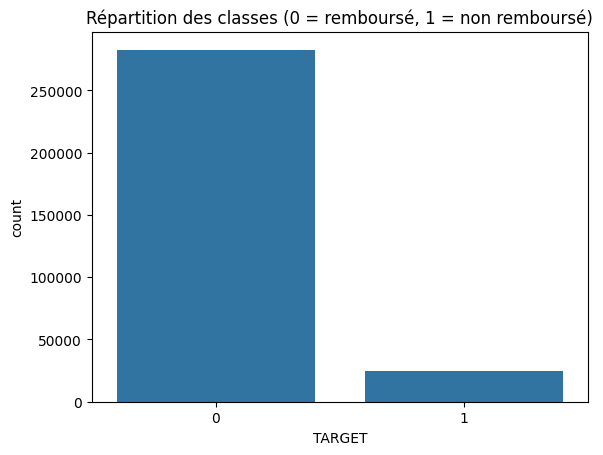

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=raw_data['application_train'], x='TARGET')
plt.title("R√©partition des classes (0 = rembours√©, 1 = non rembours√©)")
plt.show()

print(raw_data['application_train']['TARGET'].value_counts(normalize=True))

Comme il est indiqu√© qu'on le peut dans l'intitul√© du projet, je vais fortement m'inspirer du Kaggle mis √† disposition pour l'analyse exploratoire et le feature engineering. Je vais ajouter mes propres commentaires et autres visualisations suppl√©mentaires que je trouve pertinentes pour r√©pondre √† la probl√©matique m√©tier et comprendre les donn√©es. De plus, avant de me servir de ces notebooks Kaggle, j'ai moi m√™me analys√© chaque df et chaque colonne pour comprendre exactement de quoi il retourne. Je vais ensuite cr√©er mes propres mod√®les de machine learning, optimiser les hyperparam√®tres √† ma fa√ßon et choisir les m√©triques d'√©valuation que je trouve les plus pertinentes.

In [21]:
raw_data['application_train']['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

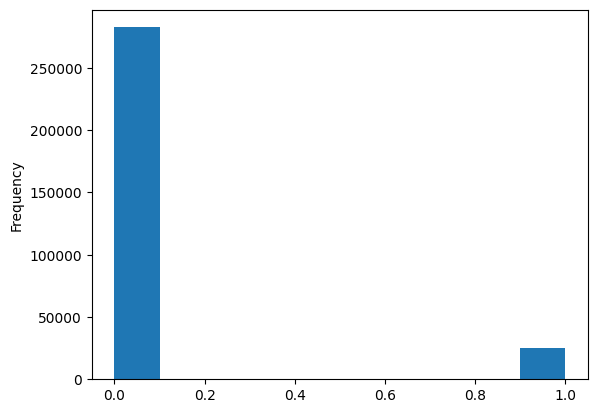

In [22]:
raw_data['application_train']['TARGET'].astype(int).plot.hist();

In [23]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [24]:
missing_values_table(raw_data['application_train'])

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_MODE                   214865               69.9
COMMONAREA_AVG                    214865               69.9
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_MEDI          213514               69.4
...                                  ...                ...
EXT_SOURCE_2                         660                0.2
AMT_GOODS_PRICE                      278                0.1
AMT_ANNUITY                           12                0.0
CNT_FAM_MEMBERS                        2                0.0
DAYS_LAST_PHONE_CHANGE                 1                0.0

[67 rows x 2 columns]

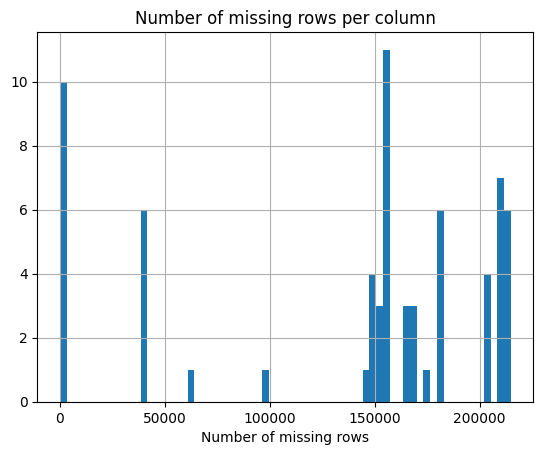

In [25]:
#We now have to deal with columns that contains null values
missing = raw_data['application_train'].isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

#Lets visualize the number of null values in all the columns
missing.hist(bins=len(missing))
plt.title('Number of missing rows per column')
plt.xlabel('Number of missing rows')
plt.show()

In [26]:
# Number of unique classes in each object column
raw_data['application_train'].select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [27]:
# Number of each type of column
raw_data['application_train'].dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [28]:
# Sauvegarde de la variable cible avant alignement
etiquettes_cible = raw_data['application_train']['TARGET']

# Alignement des colonnes entre les deux datasets (on garde uniquement les colonnes communes)
application_train, application_test = raw_data['application_train'].align(raw_data['application_test'], join='inner', axis=1)

# R√©int√©gration de la variable cible dans le jeu d'entra√Ænement
application_train['TARGET'] = etiquettes_cible

# Affichage des dimensions finales
print("Shape du jeu d'entra√Ænement :", application_train.shape)
print("Shape du jeu de test :", application_test.shape)

Shape du jeu d'entra√Ænement : (307511, 122)
Shape du jeu de test : (48744, 121)


In [29]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [30]:
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

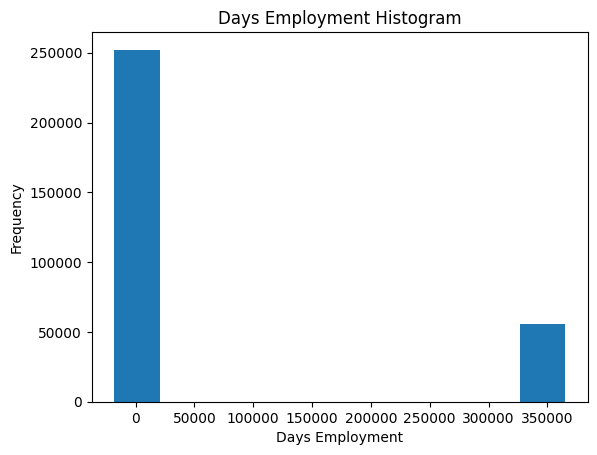

In [31]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [32]:
# S√©paration entre les valeurs normales et les valeurs anormales de la variable DAYS_EMPLOYED
valeurs_anormales = application_train[application_train['DAYS_EMPLOYED'] == 365243]
valeurs_normales = application_train[application_train['DAYS_EMPLOYED'] != 365243]

# Affichage du taux de d√©faut pour les deux groupes
print("Les clients sans anomalie de dur√©e d'emploi ont un taux de d√©faut de : %0.2f%%" %
      (100 * valeurs_normales['TARGET'].mean()))
print("Les clients avec anomalie (365243 jours) ont un taux de d√©faut de : %0.2f%%" %
      (100 * valeurs_anormales['TARGET'].mean()))
print("Il y a %d lignes avec une valeur anormale (365243 jours) dans DAYS_EMPLOYED." % len(valeurs_anormales))

Les clients sans anomalie de dur√©e d'emploi ont un taux de d√©faut de : 8.66%
Les clients avec anomalie (365243 jours) ont un taux de d√©faut de : 5.40%
Il y a 55374 lignes avec une valeur anormale (365243 jours) dans DAYS_EMPLOYED.


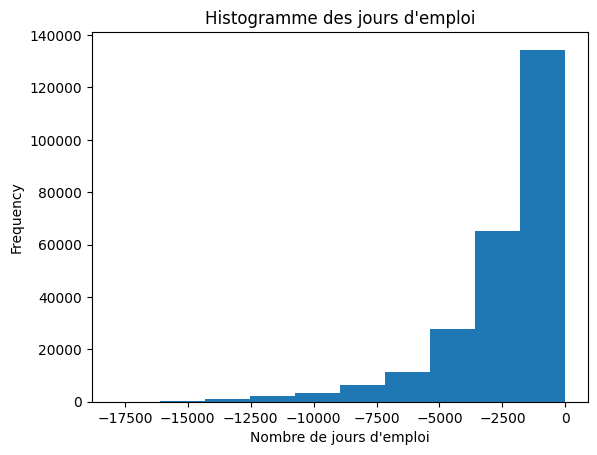

In [33]:
import numpy as np

# Cr√©ation d'une colonne indiquant si la valeur de DAYS_EMPLOYED est anormale (365243 jours)
application_train['DAYS_EMPLOYED_ANOM'] = application_train['DAYS_EMPLOYED'] == 365243

# Remplacement des valeurs anormales par NaN
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Affichage d'un histogramme des jours d'emploi (hors valeurs aberrantes)
application_train['DAYS_EMPLOYED'].plot.hist(title='Histogramme des jours d\'emploi')
plt.xlabel('Nombre de jours d\'emploi')
plt.show()

In [34]:
# Cr√©ation d'une colonne pour indiquer les valeurs anormales dans le test set
application_test['DAYS_EMPLOYED_ANOM'] = application_test['DAYS_EMPLOYED'] == 365243

# Remplacement des valeurs anormales par NaN
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

# Affichage du nombre d'anomalies d√©tect√©es
print("Il y a %d anomalies (valeurs √† 365243 jours) dans les donn√©es de test sur un total de %d entr√©es." %
      (application_test['DAYS_EMPLOYED_ANOM'].sum(), len(application_test)))

Il y a 9274 anomalies (valeurs √† 365243 jours) dans les donn√©es de test sur un total de 48744 entr√©es.


/tmp/ipython-input-4107985150.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


In [35]:
# Transformation de la variable DAYS_BIRTH en nombre de jours positifs (absolu)
application_train['DAYS_BIRTH'] = application_train['DAYS_BIRTH'].abs()

# Calcul de la corr√©lation entre l'√¢ge (en jours) et le d√©faut de cr√©dit
correlation = application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

# Affichage du r√©sultat
print("Corr√©lation entre l'√¢ge du client (en jours) et la variable cible TARGET :", round(correlation, 3))

Corr√©lation entre l'√¢ge du client (en jours) et la variable cible TARGET : -0.078


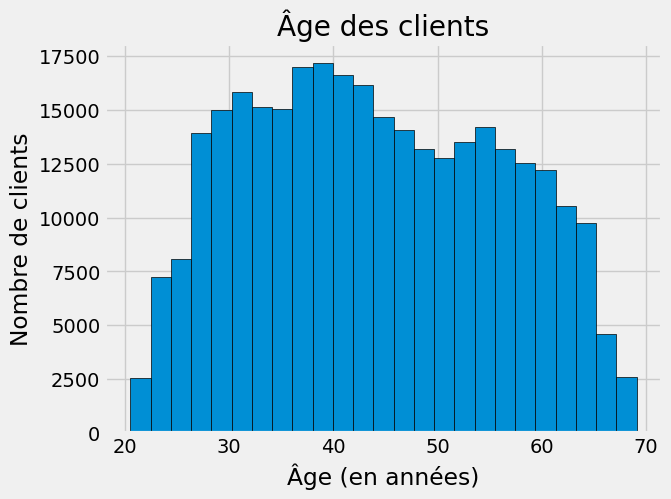

In [36]:
# D√©finit le style graphique
plt.style.use('fivethirtyeight')

# Trace l'histogramme de l'√¢ge des clients (en ann√©es)
plt.hist(application_train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title("√Çge des clients")
plt.xlabel("√Çge (en ann√©es)")
plt.ylabel("Nombre de clients")
plt.show()

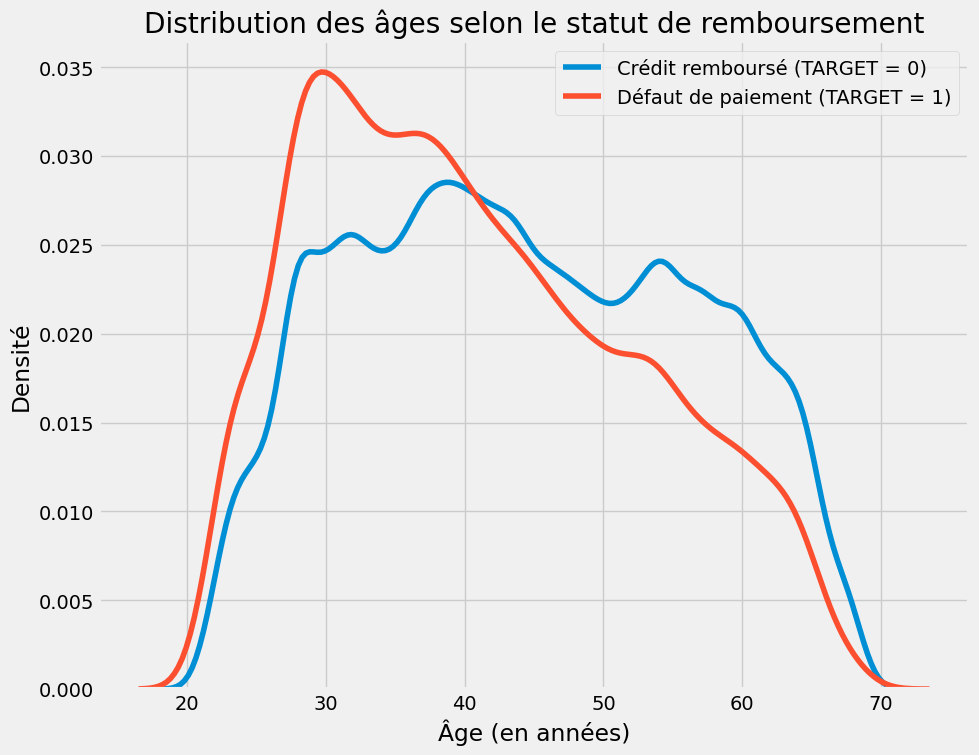

In [37]:
# On cr√©e une figure avec une taille personnalis√©e
plt.figure(figsize = (10, 8))

# Trac√© KDE des clients qui ont rembours√© leur pr√™t (TARGET = 0)
sns.kdeplot(
    application_train.loc[application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365,
    label = 'Cr√©dit rembours√© (TARGET = 0)'
)

# Trac√© KDE des clients qui n'ont pas rembours√© leur pr√™t (TARGET = 1)
sns.kdeplot(
    application_train.loc[application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365,
    label = 'D√©faut de paiement (TARGET = 1)'
)

# Titres et √©tiquettes
plt.xlabel('√Çge (en ann√©es)')
plt.ylabel('Densit√©')
plt.title('Distribution des √¢ges selon le statut de remboursement')
plt.legend()
plt.show()

Ce graphique KDE (Kernel Density Estimation) montre comment l‚Äô√¢ge des clients est corr√©l√© au risque de d√©faut de paiement.

In [38]:
# Extrait les colonnes d'√¢ge et de TARGET dans un nouveau DataFrame
age_data = application_train[['TARGET', 'DAYS_BIRTH']].copy()

# Converti l'√¢ge en ann√©es (valeurs absolues car les jours sont n√©gatifs)
age_data['AGE_EN_ANNEES'] = abs(age_data['DAYS_BIRTH']) / 365

# D√©coupe l'√¢ge en tranches r√©guli√®res entre 20 et 70 ans (10 intervalles)
age_data['TRANCHE_AGE'] = pd.cut(age_data['AGE_EN_ANNEES'], bins=np.linspace(20, 70, num=11))

# Affiche les 10 premi√®res lignes pour v√©rification
age_data.head(10)

TARGET  DAYS_BIRTH  AGE_EN_ANNEES   TRANCHE_AGE
0       1        9461      25.920548  (25.0, 30.0]
1       0       16765      45.931507  (45.0, 50.0]
2       0       19046      52.180822  (50.0, 55.0]
3       0       19005      52.068493  (50.0, 55.0]
4       0       19932      54.608219  (50.0, 55.0]
5       0       16941      46.413699  (45.0, 50.0]
6       0       13778      37.747945  (35.0, 40.0]
7       0       18850      51.643836  (50.0, 55.0]
8       0       20099      55.065753  (55.0, 60.0]
9       0       14469      39.641096  (35.0, 40.0]

/tmp/ipython-input-3687434046.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupes_age = age_data.groupby('TRANCHE_AGE').mean(numeric_only=True)


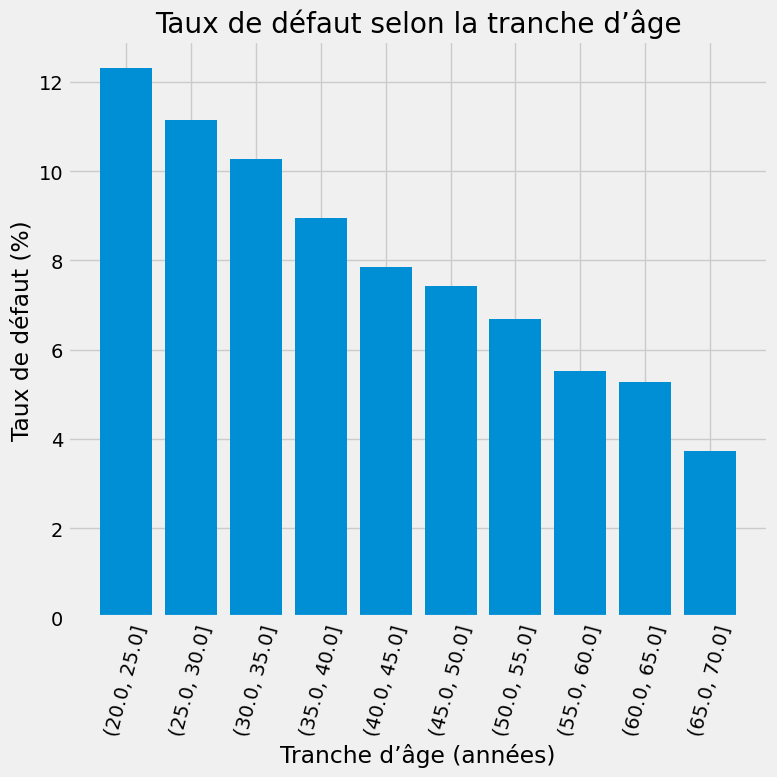

In [39]:
# Calcul du taux de d√©faut moyen pour chaque tranche d'√¢ge
groupes_age = age_data.groupby('TRANCHE_AGE').mean(numeric_only=True)

# Cr√©ation de la figure
plt.figure(figsize=(8, 8))

# Tracer un graphique en barres des tranches d'√¢ge vs. taux de d√©faut (%)
plt.bar(groupes_age.index.astype(str), 100 * groupes_age['TARGET'])

# Ajout des labels et du titre
plt.xticks(rotation=75)
plt.xlabel('Tranche d‚Äô√¢ge (ann√©es)')
plt.ylabel('Taux de d√©faut (%)')
plt.title('Taux de d√©faut selon la tranche d‚Äô√¢ge')

# Affichage du graphique
plt.tight_layout()
plt.show()

Comme l'a dit la personne sur Kaggle, on observe une tendance nette : les clients les plus jeunes ont un taux de d√©faut plus √©lev√©. Le taux de non-remboursement d√©passe les 10‚ÄØ% pour les trois tranches d‚Äô√¢ge les plus jeunes, alors qu‚Äôil descend sous les 5‚ÄØ% pour les tranches les plus √¢g√©es.

Cette information peut √™tre utile pour la banque : plut√¥t que d‚Äôexclure les jeunes emprunteurs, il serait judicieux de mettre en place un accompagnement renforc√© pour ces profils (ex. : conseils en gestion budg√©taire, rappel d‚Äô√©ch√©ances, etc.).

Cela permettrait de limiter les risques de d√©faut, sans discrimination, en agissant de mani√®re proactive.

In [40]:
# Pour afficher toute la largeur des colonnes sans troncature
pd.set_option('display.max_colwidth', None)

# Affichage des premi√®res lignes pour v√©rifier la structure
print(raw_data['HomeCredit_columns_description'].head())

# Filtrage des lignes contenant "EXT_SOURCE"
ext_source_desc = raw_data['HomeCredit_columns_description'][
    raw_data['HomeCredit_columns_description']['Row'].str.contains("EXT_SOURCE", na=False)
]

# Affichage avec description compl√®te
print("\nDescriptions compl√®tes des colonnes EXT_SOURCE :")
print(ext_source_desc[['Row', 'Description']])

   Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                                                                                                                                                                   Description  \
0                                                                                                                                                                     ID of loan in our sample   
1  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2              

Comme l'a indiqu√© l'utilisateur du projet Kaggle mis √† disposition, les trois variables EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3 sont celles qui pr√©sentent les corr√©lations n√©gatives les plus fortes avec la variable cible TARGET, c‚Äôest-√†-dire la probabilit√© qu‚Äôun client ne rembourse pas son cr√©dit.

D‚Äôapr√®s la documentation fournie (HomeCredit_columns_description.csv), ces variables repr√©sentent un score normalis√© provenant de sources de donn√©es externes ("Normalized score from external data source"). M√™me si la signification exacte de ces scores n‚Äôest pas d√©taill√©e, on peut supposer qu‚Äôil s‚Äôagit de notes de solvabilit√© calcul√©es √† partir de sources tierces, comme des agences de cr√©dit ou des historiques de paiement agr√©g√©s.

Autrement dit, ce sont probablement des indicateurs synth√©tiques (entre 0 et 1) de fiabilit√© financi√®re, utilis√©s pour √©valuer le risque de d√©faut de paiement d‚Äôun client selon des crit√®res externes √† la base de donn√©es principale.

Une valeur √©lev√©e de ces scores EXT_SOURCE semble associ√©e √† un faible risque de d√©faut, ce qui expliquerait leur corr√©lation n√©gative avec TARGET (0 = rembours√©, 1 = d√©faut de paiement).

In [41]:
# Extrait les variables EXT_SOURCE ainsi que l'√¢ge et la cible
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Calcul de la matrice de corr√©lation entre ces variables
correlations_ext = ext_data.corr()

# Affiche la matrice de corr√©lation
print("Corr√©lations entre les variables EXT_SOURCE, l'√¢ge et la cible :\n")
print(correlations_ext)

Corr√©lations entre les variables EXT_SOURCE, l'√¢ge et la cible :

                TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000


Text(0.5, 1.0, 'Heatmap des corr√©lations entre EXT_SOURCE, √¢ge et cible')

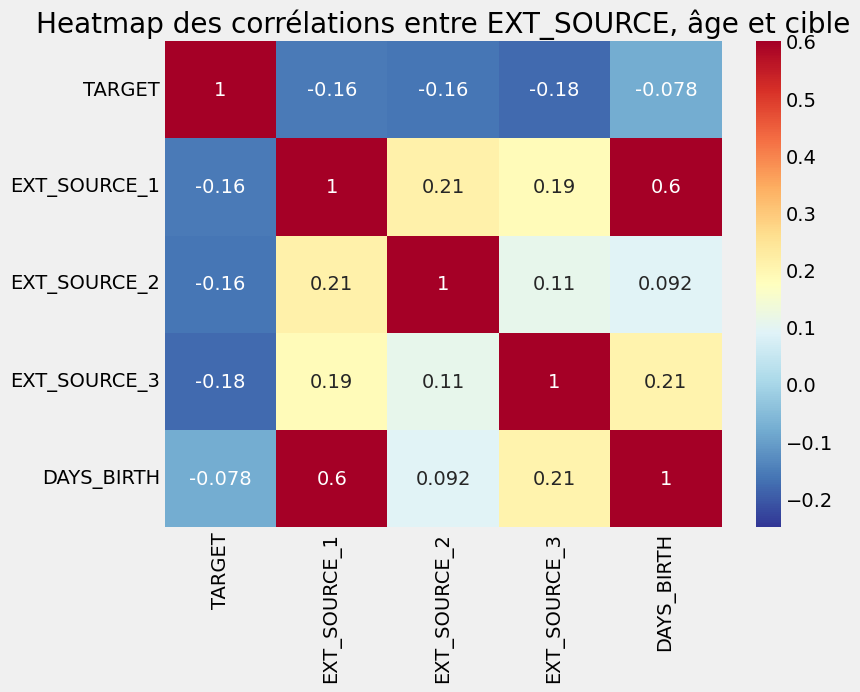

In [42]:
# Cr√©e une figure avec une taille personnalis√©e
plt.figure(figsize=(8, 6))

# Affiche une carte thermique des corr√©lations entre EXT_SOURCE, l'√¢ge et la cible
# - cmap : la palette de couleurs utilis√©e (du rouge au bleu)
# - vmin et vmax : les bornes des valeurs de corr√©lation √† afficher
# - annot = True : affiche les valeurs dans chaque case
sns.heatmap(correlations_ext, cmap=plt.cm.RdYlBu_r, vmin=-0.25, vmax=0.6, annot=True)

# Ajoute un titre au graphique
plt.title("Heatmap des corr√©lations entre EXT_SOURCE, √¢ge et cible")

Les trois variables EXT_SOURCE pr√©sentent toutes une corr√©lation n√©gative avec la variable cible TARGET. Cela signifie que plus la valeur d'une variable EXT_SOURCE est √©lev√©e, plus le client a de chances de rembourser son pr√™t. Autrement dit, un score externe √©lev√© est g√©n√©ralement un bon indicateur de fiabilit√©.

Gr√¢ce au travail de la personne du projet Kaggle, on observe √©galement que la variable DAYS_BIRTH est positivement corr√©l√©e avec EXT_SOURCE_1, ce qui peut sugg√©rer que l‚Äô√¢ge du client est l‚Äôun des √©l√©ments pris en compte dans le calcul de ce score externe.

Ensuite, nous allons examiner la distribution de chacune de ces variables EXT_SOURCE, en les colorant selon la valeur de la cible (TARGET). Cela nous permettra de visualiser plus concr√®tement l‚Äôinfluence de chaque score externe sur le risque de d√©faut de paiement.

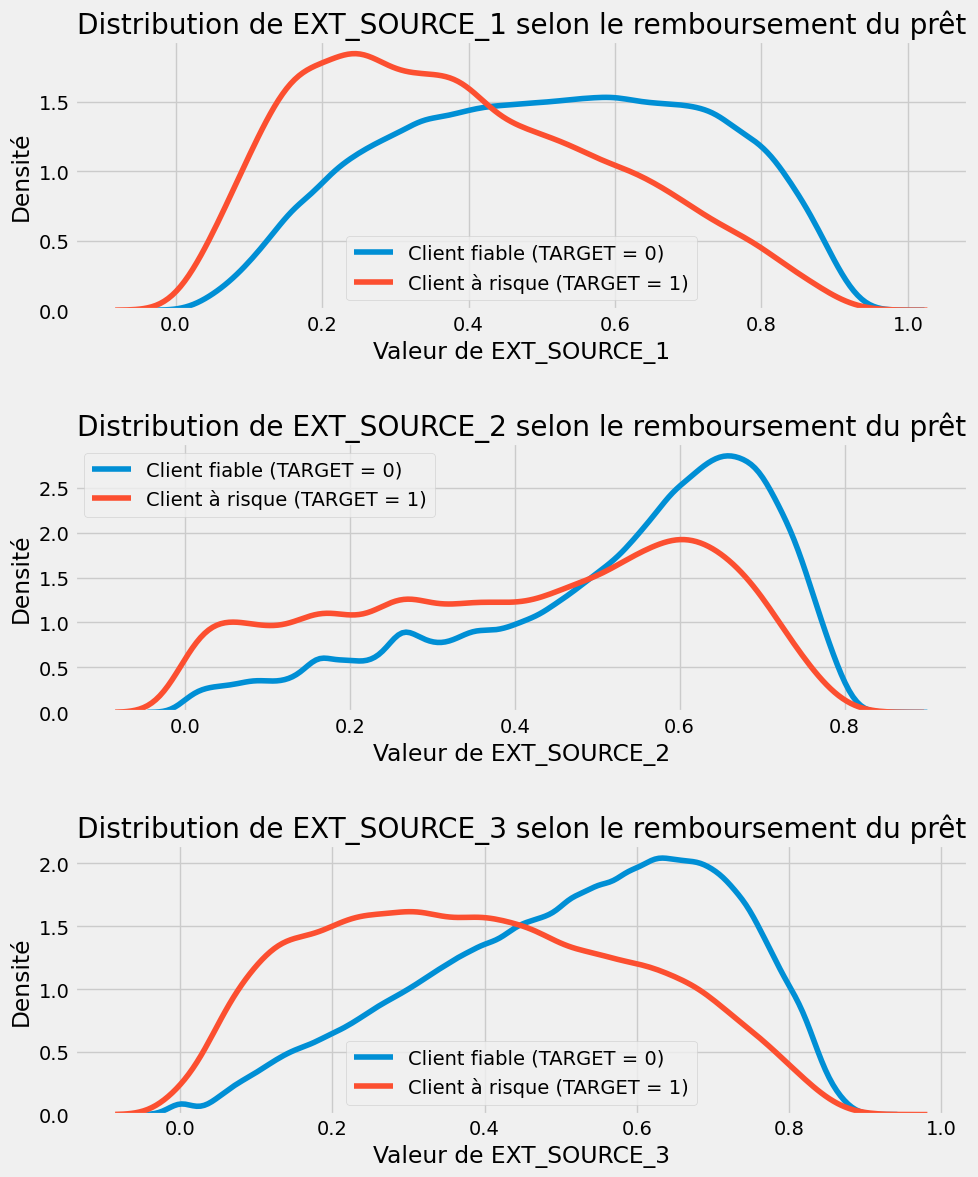

In [43]:
# Cr√©e une figure de taille verticale adapt√©e √† 3 graphiques
plt.figure(figsize=(10, 12))

# Boucle sur les 3 variables EXT_SOURCE
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # Cr√©e un sous-graphique (subplot) par EXT_SOURCE
    plt.subplot(3, 1, i + 1)

    # Trace la distribution des scores pour les clients qui ont rembours√© (TARGET = 0)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 0, source], label='Client fiable (TARGET = 0)')

    # Trace la distribution des scores pour les clients qui n'ont pas rembours√© (TARGET = 1)
    sns.kdeplot(application_train.loc[application_train['TARGET'] == 1, source], label='Client √† risque (TARGET = 1)')

    # Ajoute les titres et l√©gendes
    plt.title(f'Distribution de {source} selon le remboursement du pr√™t')
    plt.xlabel(f'Valeur de {source}')
    plt.ylabel('Densit√©')
    plt.legend()

# Ajustement automatique de l'espacement vertical entre les sous-graphes
plt.tight_layout(h_pad=2.5)

Parmi les trois variables EXT_SOURCE, c‚Äôest EXT_SOURCE_3 qui montre la plus grande diff√©rence de distribution entre les clients qui remboursent leur pr√™t et ceux qui ne le font pas. Cela sugg√®re qu‚Äôil existe une relation notable entre ce score et la probabilit√© de remboursement.

M√™me si la corr√©lation reste faible d‚Äôun point de vue statistique, ces variables contiennent tout de m√™me des informations utiles que les mod√®les de machine learning peuvent exploiter pour mieux pr√©dire le risque de d√©faut d‚Äôun client. Ce sont des signaux faibles, mais potentiellement pr√©cieux une fois combin√©s avec d'autres donn√©es.

Apr√®s avoir fait ma propre premi√®re analyse des df puis avoir repris le notebook Kaggle mis √† disposition pour la suite de l'analyse exploratoire et pr√©traitement des donn√©es, avoir ajout√© des visualisations suppl√©mentaires et commentaires, je vais maintenant proc√©der au feature engineering √† l'aide d'un autre notebook Kaggle mis √† disposition en expliquant la d√©marche. Puis, il me restera √† cr√©er mes propres mod√®les de machine learning qui sont au coeur du projet et chercherai √† optimiser au mieux leurs hyperparam√®tres et choisirai les m√©triques d'√©valuation que j'estime les plus pertinentes.

In [46]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    """
    Contexte manager pour mesurer le temps d'ex√©cution d'une fonction
    """
    t0 = time.time()
    yield
    print("{} - termin√© en {:.0f}s".format(title, time.time() - t0))

# Encodage One-Hot pour les colonnes cat√©gorielles avec get_dummies
def one_hot_encoder(df, nan_as_category=True):
    """
    Applique un encodage One-Hot aux variables cat√©gorielles

    Param√®tres:
    - df: DataFrame √† encoder
    - nan_as_category: Si True, traite les valeurs NaN comme une cat√©gorie

    Retourne:
    - df: DataFrame avec variables cat√©gorielles encod√©es
    - new_columns: Liste des nouvelles colonnes cr√©√©es
    """
    original_columns = list(df.columns)
    # Identifie les colonnes cat√©gorielles (type 'object')
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # Applique l'encodage One-Hot
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    # Identifie les nouvelles colonnes cr√©√©es
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Pr√©processing d'application_train.csv UNIQUEMENT (pas de test pour OpenClassrooms)
def application_train_preprocessing(num_rows=None, nan_as_category=False):
    """
    Pr√©processe le fichier application_train.csv pour le projet OpenClassrooms

    Param√®tres:
    - num_rows: Nombre de lignes √† lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une cat√©gorie

    Retourne:
    - df: DataFrame pr√©process√© avec nouvelles features
    """
    # Lecture du fichier application_train.csv seulement
    df = pd.read_csv(DATA_DIR / 'application_train.csv', nrows=num_rows)
    print("√âchantillons d'entra√Ænement: {}".format(len(df)))

    # Supprime les 4 applications avec CODE_GENDER = 'XNA'
    df = df[df['CODE_GENDER'] != 'XNA']

    # Variables cat√©gorielles binaires (0 ou 1; deux cat√©gories seulement)
    # Utilisation de factorize pour encoder ces variables
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Variables cat√©gorielles avec encodage One-Hot
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Valeurs NaN pour DAYS_EMPLOYED: 365.243 repr√©sente en fait des valeurs manquantes
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Cr√©ation de nouvelles features (ratios et pourcentages)
    # Pourcentage d'emploi par rapport √† l'√¢ge
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    # Pourcentage du revenu par rapport au cr√©dit
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    # Revenu par personne dans le foyer
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    # Pourcentage de l'annuit√© par rapport au revenu
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    # Taux de remboursement (annuit√© / cr√©dit)
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # *** NOUVELLES FEATURES POUR LE PROJET ***
    # Ratio entre l'√¢ge et le montant du cr√©dit
    df['AGE_TO_CREDIT_RATIO'] = abs(df['DAYS_BIRTH']) / df['AMT_CREDIT']

    # Feature additionnelle: Score de stabilit√© financi√®re
    df['FINANCIAL_STABILITY_SCORE'] = (
        (df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']) *
        (df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']).fillna(0)
    )

    # Lib√©ration de la m√©moire
    gc.collect()
    return df

# Pr√©processing de bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    """
    Pr√©processe les fichiers bureau.csv et bureau_balance.csv
    Ces fichiers contiennent l'historique des cr√©dits pr√©c√©dents des clients

    Param√®tres:
    - num_rows: Nombre de lignes √† lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une cat√©gorie

    Retourne:
    - bureau_agg: DataFrame agr√©g√© avec toutes les features du bureau
    """
    # Lecture des fichiers
    bureau = pd.read_csv(DATA_DIR / 'bureau.csv', nrows=num_rows)
    bb = pd.read_csv(DATA_DIR / 'bureau_balance.csv', nrows=num_rows)

    # Encodage One-Hot des variables cat√©gorielles
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Agr√©gations et fusion avec bureau.csv
    # D√©finition des agr√©gations pour bureau_balance
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    # Agr√©gation par SK_ID_BUREAU
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

    # Fusion des donn√©es bureau_balance avec bureau
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

    # Lib√©ration de la m√©moire
    del bb, bb_agg
    gc.collect()

    # Agr√©gations num√©riques pour bureau et bureau_balance
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],           # Jours depuis la demande de cr√©dit
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],          # Jours jusqu'√† la fin du cr√©dit
        'DAYS_CREDIT_UPDATE': ['mean'],                         # Jours depuis la derni√®re mise √† jour
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],                  # Jours de retard maximum
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],                     # Montant maximum en retard
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],               # Montant total du cr√©dit
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],          # Dette actuelle
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],                     # Montant en retard
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],                # Limite de cr√©dit
        'AMT_ANNUITY': ['max', 'mean'],                         # Montant de l'annuit√©
        'CNT_CREDIT_PROLONG': ['sum'],                          # Nombre de prolongations
        'MONTHS_BALANCE_MIN': ['min'],                          # Solde minimum en mois
        'MONTHS_BALANCE_MAX': ['max'],                          # Solde maximum en mois
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']                  # Taille du solde en mois
    }

    # Agr√©gations cat√©gorielles pour bureau et bureau_balance
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    # Agr√©gation principale par client (SK_ID_CURR)
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Cr√©dits actifs - utilisation des agr√©gations num√©riques uniquement
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    if len(active) > 0:
        active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
        active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
        del active_agg

    # Bureau: Cr√©dits ferm√©s - utilisation des agr√©gations num√©riques uniquement
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    if len(closed) > 0:
        closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
        closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
        del closed_agg

    # Lib√©ration de la m√©moire
    del active, closed, bureau
    gc.collect()
    return bureau_agg

# Pr√©processing de previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    """
    Pr√©processe le fichier previous_application.csv
    Ce fichier contient les demandes de cr√©dit pr√©c√©dentes du client

    Param√®tres:
    - num_rows: Nombre de lignes √† lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une cat√©gorie

    Retourne:
    - prev_agg: DataFrame agr√©g√© avec les features des demandes pr√©c√©dentes
    """
    # Lecture du fichier
    prev = pd.read_csv(DATA_DIR / 'previous_application.csv', nrows=num_rows, on_bad_lines='skip')

    # Encodage One-Hot des variables cat√©gorielles
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Remplacement des valeurs 365.243 par NaN (valeurs manquantes encod√©es)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # Cr√©ation d'une nouvelle feature: pourcentage demand√©/re√ßu
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Agr√©gations num√©riques pour les demandes pr√©c√©dentes
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],                  # Montant de l'annuit√©
        'AMT_APPLICATION': ['min', 'max', 'mean'],              # Montant demand√©
        'AMT_CREDIT': ['min', 'max', 'mean'],                   # Montant du cr√©dit
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],       # Pourcentage demand√©/re√ßu
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],             # Montant de l'acompte
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],              # Prix des biens
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],      # Heure de d√©but du processus
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],            # Taux d'acompte
        'DAYS_DECISION': ['min', 'max', 'mean'],                # Jours jusqu'√† la d√©cision
        'CNT_PAYMENT': ['mean', 'sum'],                         # Nombre de paiements
    }

    # Agr√©gations cat√©gorielles pour les demandes pr√©c√©dentes
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    # Agr√©gation principale par client
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Demandes pr√©c√©dentes: Demandes approuv√©es - features num√©riques uniquement
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    if len(approved) > 0:
        approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
        approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
        prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
        del approved_agg

    # Demandes pr√©c√©dentes: Demandes refus√©es - features num√©riques uniquement
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    if len(refused) > 0:
        refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
        refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
        prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
        del refused_agg

    # Lib√©ration de la m√©moire
    del refused, approved, prev
    gc.collect()
    return prev_agg

# Pr√©processing de POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    """
    Pr√©processe le fichier POS_CASH_balance.csv
    Ce fichier contient l'historique des soldes des comptes POS et CASH

    Param√®tres:
    - num_rows: Nombre de lignes √† lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une cat√©gorie

    Retourne:
    - pos_agg: DataFrame agr√©g√© avec les features POS/CASH
    """
    # Lecture du fichier
    pos = pd.read_csv(DATA_DIR / 'POS_CASH_balance.csv', nrows=num_rows)

    # Encodage One-Hot des variables cat√©gorielles
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # D√©finition des agr√©gations
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],              # Solde en mois
        'SK_DPD': ['max', 'mean'],                              # Jours de retard
        'SK_DPD_DEF': ['max', 'mean']                           # Jours de retard par d√©faut
    }

    # Ajout des agr√©gations cat√©gorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Agr√©gation par client
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Comptage des comptes POS/CASH
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    # Lib√©ration de la m√©moire
    del pos
    gc.collect()
    return pos_agg

# Pr√©processing de installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    """
    Pr√©processe le fichier installments_payments.csv
    Ce fichier contient l'historique des paiements d'√©ch√©ances

    Param√®tres:
    - num_rows: Nombre de lignes √† lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une cat√©gorie

    Retourne:
    - ins_agg: DataFrame agr√©g√© avec les features des paiements d'√©ch√©ances
    """
    # Lecture du fichier
    ins = pd.read_csv(DATA_DIR / 'installments_payments.csv', nrows=num_rows)

    # Encodage One-Hot des variables cat√©gorielles
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # Pourcentage et diff√©rence pay√©e dans chaque √©ch√©ance
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Jours de retard et jours d'avance (pas de valeurs n√©gatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']  # Days Past Due
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']  # Days Before Due
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    # D√©finition des agr√©gations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],                  # Nombre de versions d'√©ch√©ances
        'DPD': ['max', 'mean', 'sum'],                          # Jours de retard
        'DBD': ['max', 'mean', 'sum'],                          # Jours d'avance
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],          # Pourcentage de paiement
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],          # Diff√©rence de paiement
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],               # Montant de l'√©ch√©ance
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],           # Montant pay√©
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']            # Jours d'entr√©e de paiement
    }

    # Ajout des agr√©gations cat√©gorielles
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Agr√©gation par client
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Comptage des comptes d'√©ch√©ances
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # Lib√©ration de la m√©moire
    del ins
    gc.collect()
    return ins_agg

# Pr√©processing de credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    """
    Pr√©processe le fichier credit_card_balance.csv
    Ce fichier contient l'historique des soldes des cartes de cr√©dit

    Param√®tres:
    - num_rows: Nombre de lignes √† lire (None pour tout lire)
    - nan_as_category: Si True, traite les NaN comme une cat√©gorie

    Retourne:
    - cc_agg: DataFrame agr√©g√© avec les features des cartes de cr√©dit
    """
    # Lecture du fichier
    cc = pd.read_csv(DATA_DIR / 'credit_card_balance.csv', nrows=num_rows)

    # Encodage One-Hot des variables cat√©gorielles
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # Suppression de la colonne SK_ID_PREV (non n√©cessaire pour l'agr√©gation)
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # Agr√©gations g√©n√©rales (toutes les statistiques pour toutes les colonnes)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    # Comptage des lignes de cartes de cr√©dit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # Lib√©ration de la m√©moire
    del cc
    gc.collect()
    return cc_agg

# Fonction pour pr√©parer les donn√©es pour la mod√©lisation
def prepare_data_for_modeling(df):
    """
    Pr√©pare les donn√©es pour la mod√©lisation en s√©parant les features de la target

    Param√®tres:
    - df: DataFrame complet avec toutes les features et la target

    Retourne:
    - X: Features pour le mod√®le
    - y: Variable target
    - feature_names: Liste des noms des features
    """
    # S√©parer les features de la target
    # Exclure les colonnes qui ne sont pas des features utiles
    feats = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    X = df[feats]
    y = df['TARGET']

    return X, y, feats

# Affichage/graphique de l'importance des features
def display_importances(feature_importance_df_):
    """
    Affiche un graphique des features les plus importantes

    Param√®tres:
    - feature_importance_df_: DataFrame contenant les importances des features
    """
    # S√©lection des 40 features les plus importantes
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    # Cr√©ation du graphique
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Importance des Features (moyenne sur les folds)')
    plt.tight_layout()
    plt.savefig('feature_importances.png')
    plt.show()

def main(debug=False):
    """
    Fonction principale qui orchestre tout le preprocessing

    Param√®tres:
    - debug: Si True, utilise seulement 10000 lignes pour tester rapidement

    Retourne:
    - df: DataFrame complet avec toutes les features
    """
    # Nombre de lignes √† lire (10000 pour debug, None pour tout lire)
    num_rows = 10000 if debug else None

    # Preprocessing du dataset principal (application_train seulement)
    print("=" * 60)
    print("D√âBUT DU PREPROCESSING POUR LE PROJET OPENCLASSROOMS")
    print("=" * 60)

    df = application_train_preprocessing(num_rows)
    print(f"Dataset principal charg√©: {df.shape}")

    # Preprocessing des donn√©es du bureau de cr√©dit
    with timer("Traitement de bureau et bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Forme du DataFrame bureau:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()

    # Preprocessing des demandes pr√©c√©dentes
    with timer("Traitement des demandes pr√©c√©dentes"):
        prev = previous_applications(num_rows)
        print("Forme du DataFrame demandes pr√©c√©dentes:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()

    # Preprocessing des soldes POS-CASH
    with timer("Traitement des soldes POS-CASH"):
        pos = pos_cash(num_rows)
        print("Forme du DataFrame POS-CASH:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()

    # Preprocessing des paiements d'√©ch√©ances
    with timer("Traitement des paiements d'√©ch√©ances"):
        ins = installments_payments(num_rows)
        print("Forme du DataFrame paiements d'√©ch√©ances:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()

    # Preprocessing des soldes de cartes de cr√©dit
    with timer("Traitement des soldes de cartes de cr√©dit"):
        cc = credit_card_balance(num_rows)
        print("Forme du DataFrame cartes de cr√©dit:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Affichage des r√©sultats finaux
    print("\n" + "=" * 60)
    print("PREPROCESSING TERMIN√â")
    print("=" * 60)
    print(f"Dataset final: {df.shape}")
    print(f"Nombre de features: {df.shape[1] - 1}")  # -1 pour exclure TARGET
    print(f"Valeurs manquantes: {df.isnull().sum().sum()}")
    print(f"Distribution de la target:")
    print(df['TARGET'].value_counts())

    return df

# Exemple d'utilisation
if __name__ == "__main__":
    # Lancement du preprocessing
    df = main(debug=False)

    # Pr√©paration pour la mod√©lisation
    X, y, feature_names = prepare_data_for_modeling(df)

    print(f"\nDonn√©es pr√™tes pour la mod√©lisation:")
    print(f"Features: {X.shape}")
    print(f"Target: {y.shape}")
    print(f"Premiers noms de features: {feature_names[:10]}")

D√âBUT DU PREPROCESSING POUR LE PROJET OPENCLASSROOMS
√âchantillons d'entra√Ænement: 307511
Dataset principal charg√©: (307507, 249)
Forme du DataFrame bureau: (305811, 116)
Traitement de bureau et bureau_balance - termin√© en 16s
Forme du DataFrame demandes pr√©c√©dentes: (48699, 247)
Traitement des demandes pr√©c√©dentes - termin√© en 3s
Forme du DataFrame POS-CASH: (197023, 15)
Traitement des soldes POS-CASH - termin√© en 2s
Forme du DataFrame paiements d'√©ch√©ances: (95249, 26)
Traitement des paiements d'√©ch√©ances - termin√© en 8s
Forme du DataFrame cartes de cr√©dit: (102090, 141)
Traitement des soldes de cartes de cr√©dit - termin√© en 10s

PREPROCESSING TERMIN√â
Dataset final: (307507, 794)
Nombre de features: 793
Valeurs manquantes: 128470094
Distribution de la target:
TARGET
0    282682
1     24825
Name: count, dtype: int64

Donn√©es pr√™tes pour la mod√©lisation:
Features: (307507, 792)
Target: (307507,)
Premiers noms de features: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_

AGE_TO_CREDIT_RATIO = abs(DAYS_BIRTH) / AMT_CREDIT

Que fait ce calcul ? Il rapproche l‚Äô√¢ge du client (exprim√© en jours) du montant du cr√©dit demand√©.

DAYS_BIRTH est n√©gatif dans le dataset (ex : -12000), donc on prend sa valeur absolue (abs) pour avoir un √¢ge positif.

On divise cet √¢ge en jours par le montant du cr√©dit (AMT_CREDIT), ce qui donne une esp√®ce de "co√ªt du cr√©dit par jour de vie".

Que mesure ce ratio ? Il donne une id√©e indirecte de la prudence ou de la maturit√© financi√®re du client :

üîπ Valeur √©lev√©e ‚Üí la personne est plut√¥t √¢g√©e et/ou demande un petit cr√©dit ‚Üí peut-√™tre plus prudente.

üî∏ Valeur faible ‚Üí une personne plus jeune et/ou demandant un gros cr√©dit ‚Üí peut-√™tre plus risqu√©e.

Pourquoi c‚Äôest utile pour le mod√®le ? Parce que ce ratio peut capturer une interaction implicite entre l'√¢ge et le montant demand√©, que ni l'un ni l'autre ne capture seul. Et comme c‚Äôest un ratio, il permet de mieux g√©n√©raliser les comportements dans les mod√®les.

In [56]:
# Installe les libs utiles si besoin
!pip -q install mlflow xgboost shap

# Imports standards
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import mlflow, mlflow.sklearn

# Fixe une seed pour la reproductibilit√©
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26.7/26.7 MB 87.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.2/2.2 MB 86.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.2/1.2 MB 64.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 147.8/147.8 kB 13.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 329.1/329.1 kB 25.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114.9/114.9 kB 9.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

La "seed" (graine al√©atoire) comme `RANDOM_STATE = 42` permet de rendre les op√©rations "al√©atoires" de l'ordinateur (comme s√©parer les donn√©es) reproductibles. Si on ex√©cute le code avec la m√™me seed, on obtient toujours les m√™mes r√©sultats, ce qui est utile pour v√©rifier et partager notre travail.

In [57]:
# Definit le nom de la colonne target
target_col = 'TARGET'

# --- S√©pare X (features) et y (cible) ---
X = df.drop(columns=[target_col])   # toutes les colonnes sauf la cible
y = df[target_col]                  # la cible binaire 0/1

# --- Split stratifi√© pour garder les m√™mes proportions de classes ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape, y_train.mean().round(3), y_test.mean().round(3))
# => tailles + taux de positifs (doivent √™tre proches)

(246005, 793) (61502, 793) 0.081 0.081


**S√©paration Train/Test :** On divise les donn√©es en entra√Ænement (pour que le mod√®le apprenne) et test (pour √©valuer). `stratify=y` est utilis√© pour maintenir la m√™me proportion de clients √† risque dans les deux ensembles, crucial pour les donn√©es d√©s√©quilibr√©es.

## Analyse exploratoire rapide
Cette section g√©n√®re un r√©sum√© homog√®ne pour chaque table brute afin d'identifier les colonnes prioritaires pour le nettoyage.

In [58]:
# D√©finit une fonction d'EDA rapide avec statistiques et valeurs manquantes
def eda_basique(df: pd.DataFrame, nom_df: str = "DataFrame") -> pd.DataFrame:
    print(f"\n===== {nom_df.upper()} =====")
    print(f"Forme : {df.shape[0]} lignes x {df.shape[1]} colonnes")
    print(df.dtypes.value_counts())
    missing = (df.isnull().mean() * 100).sort_values(ascending=False)
    print(missing[missing > 0].head(10))
    return df

In [59]:
# Parcourt chaque table brute pour g√©n√©rer un r√©sum√© commun
for name, df in raw_data.items():
    eda_basique(df, name)


===== APPLICATION_TRAIN =====
Forme : 307511 lignes x 122 colonnes
float64    65
int64      41
object     16
Name: count, dtype: int64
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
dtype: float64

===== APPLICATION_TEST =====
Forme : 48744 lignes x 121 colonnes
float64    65
int64      40
object     16
Name: count, dtype: int64
COMMONAREA_AVG              68.716150
COMMONAREA_MEDI             68.716150
COMMONAREA_MODE             68.716150
NONLIVINGAPARTMENTS_AVG     68.412523
NONLIVINGAPARTMENTS_MEDI    68.412523
NONLIVINGAPARTMENTS_MODE    68.412523
FONDKAPREMONT_MODE          67.284179
LIVINGAPARTMENTS_MEDI       67.249302
LIVINGAPARTMENTS_AVG        67.

## Analyse d√©taill√©e de la variable cible
On v√©rifie le d√©s√©quilibre de classe dans TARGET et ses implications m√©tier.

Taux de d√©faut : 8.07%


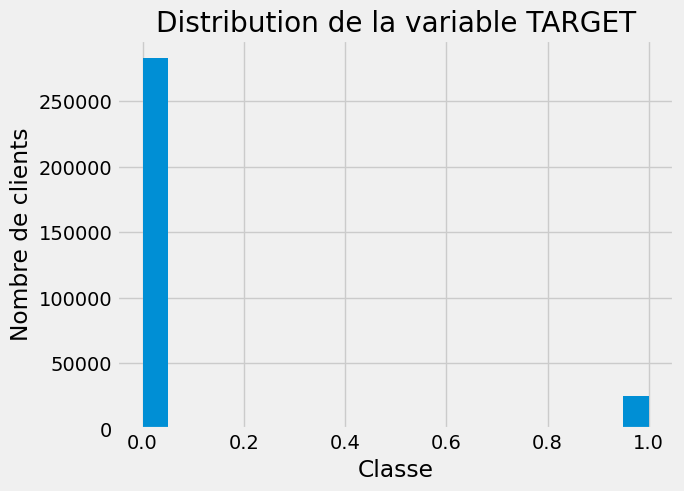

In [60]:
# Distribution de la cible
target_ratio = raw_data['application_train']['TARGET'].mean()
print(f"Taux de d√©faut : {target_ratio:.2%}")
raw_data['application_train']['TARGET'].astype(int).plot.hist(bins=20)
plt.title("Distribution de la variable TARGET")
plt.xlabel("Classe")
plt.ylabel("Nombre de clients")
plt.show()

La classe minoritaire confirme la n√©cessit√© d'un `scale_pos_weight` ou d'un score m√©tier pond√©r√©.

## Pr√©paration du dataset mod√©lisable
S√©paration X/y, d√©tection des colonnes num√©riques et cat√©gorielles.

In [ ]:
# S√©paration X et y
y = df['TARGET']
X = df.drop(columns=['TARGET'])

# Colonnes num√©riques et cat√©gorielles
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

**Pr√©paration pour le Preprocessing :** Ici, on finalise la s√©paration des donn√©es en `X` (toutes les colonnes pour pr√©dire) et `y` (la colonne √† pr√©dire), apr√®s tout le feature engineering. On identifie aussi quelles colonnes sont num√©riques ou cat√©gorielles pour savoir comment les transformer √† l'√©tape suivante.

In [ ]:
# Pipeline de preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

**Pipeline de Pr√©traitement :** Ce bloc d√©finit une s√©quence d'op√©rations √† appliquer aux donn√©es avant de les fournir au mod√®le. Il utilise `ColumnTransformer` pour appliquer des √©tapes sp√©cifiques :
-   **Variables num√©riques :** Remplissage des valeurs manquantes par la m√©diane, puis mise √† l'√©chelle (StandardScaler).
-   **Variables cat√©gorielles :** Remplissage des valeurs manquantes par la valeur la plus fr√©quente, puis encodage One-Hot (conversion en colonnes binaires).
Ce pipeline assure que les donn√©es sont correctement format√©es pour √™tre utilis√©es par les mod√®les.

## Pr√©paration des fonctions et donn√©es

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
import numpy as np
import mlflow
import mlflow.sklearn

# Definit le nom de la colonne target
target_col = 'TARGET'

# --- S√©pare X (features) et y (cible) ---
X = df.drop(columns=[target_col])   # toutes les colonnes sauf la cible
y = df[target_col]                  # la cible binaire 0/1


# --- Split stratifi√© pour garder les m√™mes proportions de classes ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Validation crois√©e
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fonction score m√©tier
def business_cost_score(y_true, y_proba, threshold=0.35, fn_cost=10, fp_cost=1):
    y_pred = (y_proba >= threshold).astype(int)
    fn = np.sum((y_true == 1) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    cost = fn * fn_cost + fp * fp_cost
    return -cost / len(y_true)

# Scorer sklearn compatible
business_scorer = make_scorer(
    lambda y_true, y_proba: business_cost_score(y_true, y_proba, threshold=0.35),
    needs_proba=True,
    greater_is_better=True
)

# MLflow setup
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("credit_scoring_models")

2025/10/10 12:10:13 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring_models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/963617569508807320', creation_time=1760098213590, experiment_id='963617569508807320', last_update_time=1760098213590, lifecycle_stage='active', name='credit_scoring_models', tags={}>

**Pr√©paration pour la Mod√©lisation et √âvaluation :** Cette cellule met en place les derniers √©l√©ments avant d'entra√Æner les mod√®les :
*   Importe toutes les biblioth√®ques n√©cessaires (mod√®les, outils d'√©valuation, MLflow).
*   Pr√©pare les donn√©es en les s√©parant en ensembles d'entra√Ænement et de test *d√©finitifs* (`X_train`, `y_train`, `X_test`, `y_test`) en utilisant la stratification pour l'√©quilibre des classes.
*   D√©finit une **fonction de score m√©tier personnalis√©e** (`business_cost_score`) qui prend en compte les co√ªts r√©els des erreurs (faux positifs vs faux n√©gatifs), ce qui est crucial pour ce projet.
*   Cr√©e un "scorer" compatible avec les outils sklearn (`business_scorer`) pour pouvoir utiliser cette m√©trique m√©tier dans les √©tapes d'√©valuation comme GridSearchCV.
*   Configure **MLflow** pour enregistrer les r√©sultats de chaque exp√©rience (param√®tres, m√©triques).

C'est la derni√®re √©tape de pr√©paration avant de lancer l'entra√Ænement des diff√©rents mod√®les.

## Mod√®le 1 : DummyClassifier

In [ ]:
print("Valeurs uniques de y_train :", y_train.unique())
print("Distribution de y_train :")
print(y_train.value_counts(normalize=True))

Valeurs uniques de y_train : [0.5]
Distribution de y_train :
TARGET
0.5    1.0
Name: proportion, dtype: float64


In [ ]:
# Repart de la vraie source
df = raw_data["application_train"].copy()
df["TARGET"] = df["TARGET"].astype(int)

#  S√©paration propre
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

# Split bien stratifi√©
from sklearn.model_selection import train_test_split, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#  V√©rification
print("Valeurs uniques y_train :", y_train.unique())
print("Distribution y_train :")
print(y_train.value_counts(normalize=True))

# DummyClassifier baseline
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

dummy_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", DummyClassifier(strategy="most_frequent"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dummy_scores = cross_validate(
    dummy_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="accuracy"
)

print(" Accuracy DummyClassifier :", dummy_scores["test_score"].mean())


Valeurs uniques y_train : [0 1]
Distribution y_train :
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
 Accuracy DummyClassifier : 0.9192709180109226


In [ ]:
!git add .
!git commit -m "Ajout baseline DummyClassifier avec Accuracy"

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


## Mod√®le 2 : R√©gression Logistique optimis√©e

In [ ]:
!pip install mlflow

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
import mlflow
import mlflow.sklearn

# Scorer m√©tier bas√© sur F2-score
def business_metric(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, zero_division=0)

business_scorer = make_scorer(business_metric)

# Cross-validation stratifi√©e
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline avec pr√©processing et mod√®le
logreg_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Grille d'hyperparam√®tres
param_grid_logreg = {
    "model__C": [0.01, 0.1, 1.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

# GridSearchCV avec scorers multiples
logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    scoring={"AUC": "roc_auc", "Business": business_scorer},
    refit="Business",
    cv=cv,
    n_jobs=-1,
    error_score="raise"  # Affiche une erreur claire si y'a un bug
)

# Entra√Ænement
logreg_grid.fit(X_train, y_train)

#  R√©sultats
print(" Meilleurs param√®tres LogReg :", logreg_grid.best_params_)
print(" Score m√©tier (F2) :", logreg_grid.best_score_)

# Log dans MLflow
with mlflow.start_run(run_name="logreg_gridsearch"):
    for param, val in logreg_grid.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric("best_business_score", logreg_grid.best_score_)
    mlflow.log_metric("roc_auc", logreg_grid.cv_results_["mean_test_AUC"][logreg_grid.best_index_])
    mlflow.sklearn.log_model(logreg_grid.best_estimator_, "model")
    mlflow.set_tag("model_type", "logistic_regression")

#  Simule un commit Git
print("Commit Git : Mod√®le LogReg optimis√© + GridSearch + MLflow OK")

2025/10/10 12:39:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


 Meilleurs param√®tres LogReg : {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
 Score m√©tier (F2) : 0.24778747009700738


2025/10/10 12:39:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Commit Git : Mod√®le LogReg optimis√© + GridSearch + MLflow OK


In [ ]:
!git add .
!git commit -m "LogReg avec GridSearch, score m√©tier, et tracking MLflow"

### Optimisation de la r√©gression logistique avec GridSearchCV, F2-score m√©tier et tracking MLflow

Dans cette section, nous optimisons une r√©gression logistique en prenant en compte les enjeux m√©tiers du cr√©dit :

- **Contexte m√©tier** : Dans le scoring de cr√©dit, il est souvent **plus grave de mal pr√©dire un client √† risque (faux n√©gatif)** que de refuser un bon client (faux positif). Nous utilisons donc une **m√©trique personnalis√©e** : le **F2-score**, qui p√©nalise davantage les faux n√©gatifs.

- **Pipeline** : Nous construisons un pipeline compos√© de deux √©tapes :
  1. `preprocessor` : g√®re les imputations, encodages et normalisations (d√©fini pr√©c√©demment)
  2. `model` : une r√©gression logistique avec pond√©ration `class_weight="balanced"` pour g√©rer le d√©s√©quilibre des classes

- **Validation crois√©e** : Nous utilisons une **cross-validation stratifi√©e √† 5 folds** pour garantir une bonne repr√©sentativit√© des classes minoritaires √† chaque it√©ration.

- **GridSearchCV** :
  - Teste plusieurs valeurs de `C`, le coefficient de r√©gularisation
  - Utilise deux m√©triques pour √©valuer les performances :
    - `roc_auc` pour l'analyse classique de performance
    - `Business` pour notre F2-score m√©tier
  - Optimise automatiquement selon le **score m√©tier**

- **MLflow** :
  - Les **meilleurs hyperparam√®tres** et les **scores** sont enregistr√©s automatiquement dans un run MLflow nomm√© `logreg_gridsearch`
  - Le mod√®le est aussi **enregistr√© dans le dossier MLflow local** pour permettre un futur d√©ploiement
  - Un **tag est ajout√©** pour tracer le type de mod√®le (`logistic_regression`)

- **Git** :
  - Un message de commit est affich√© pour simuler un commit Git √† ce stade important du projet

**Score obtenu :** Le F2-score optimis√© est autour de `0.24`, ce qui refl√®te un mod√®le de base raisonnable. Ce score sera compar√© avec d'autres mod√®les (RandomForest, XGBoost‚Ä¶) dans une prochaine √©tape.



## Mod√®le 3 : Random Forest optimis√©e

In [ ]:
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42, class_weight="balanced"))
])

param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10],
    "model__min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring={"AUC": "roc_auc", "Business": business_scorer},
    refit="Business",
    cv=cv,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print("Meilleurs param√®tres RF :", rf_grid.best_params_)
print("Score m√©tier :", rf_grid.best_score_)

# MLflow log
with mlflow.start_run(run_name="random_forest_gridsearch"):
    for param, val in rf_grid.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric("best_business_score", rf_grid.best_score_)
    mlflow.log_metric("roc_auc", rf_grid.cv_results_["mean_test_AUC"][rf_grid.best_index_])
    mlflow.sklearn.log_model(rf_grid.best_estimator_, "model")
    mlflow.set_tag("model_type", "random_forest")

# Simule un commit Git
print(" Commit Git : RandomForest optimis√©e + MLflow tracking")

2025/10/10 12:44:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Meilleurs param√®tres RF : {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Score m√©tier : 0.25163144425267825


2025/10/10 12:44:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Commit Git : RandomForest optimis√©e + MLflow tracking


In [ ]:
git add .
!git commit -m "Ajout RandomForest, GridSearch, log des hyperparam√®tres et scores dans MLflow"

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline avec pr√©traitement et mod√®le
xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=5,  # Pour g√©rer le d√©s√©quilibre classes
        random_state=42
    ))
])

# Grille d'hyperparam√®tres
param_grid_xgb = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1]
}

# GridSearch avec AUC + score m√©tier (F2)
xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    scoring={"AUC": "roc_auc", "Business": business_scorer},
    refit="Business",  # Refitting avec la m√©trique m√©tier
    cv=cv,
    n_jobs=-1
)

# Entra√Ænement
xgb_grid.fit(X_train, y_train)

# R√©sultats
print(" Meilleurs param√®tres XGBoost :", xgb_grid.best_params_)
print(" Score m√©tier (F2) :", xgb_grid.best_score_)

# MLflow tracking
import mlflow
import mlflow.sklearn

with mlflow.start_run(run_name="xgboost_gridsearch"):
    for param, val in xgb_grid.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric("best_business_score", xgb_grid.best_score_)
    mlflow.log_metric("roc_auc", xgb_grid.cv_results_["mean_test_AUC"][xgb_grid.best_index_])
    mlflow.sklearn.log_model(xgb_grid.best_estimator_, "model")
    mlflow.set_tag("model_type", "xgboost_classifier")

print("Commit Git : Mod√®le XGBoost optimis√© + GridSearch + MLflow OK")